In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# import tensor flow library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
tf.random.set_seed(42)

# import modules to graph ANN
import pydot
import pydotplus
import graphviz
import math
import scipy.stats



TFP Version 0.8.0
TF  Version 2.1.0


## Import Data

In [32]:
# Read data from files 
# get data from csv file
DataLow = pd.read_csv('Dataset.csv')
# split traing and valiating data
X_train = DataLow[['sigmaMeanNormalized' ,'nNormalized']][:28]
X_valid = DataLow[['sigmaMeanNormalized' ,'nNormalized']][26:]
Y_train = DataLow[['Target']][:28]
Y_valid = DataLow[['Target']][26:]
# get P50% & P5% Stussi data
# # get P50% 
Data = pd.read_csv('StussP50.csv')
X_train_P50 = Data['nNormalized'][0:1200]
X_valid_P50 = Data['nNormalized'][1200:]
Y_train_P50 = Data[['Target']][0:1200]
Y_valid_P50 = Data[['Target']][1200:]

# get experimental data
ExpData= pd.read_csv('Experimental Data.csv')
# split traing and valiating data
ExpX_train = ExpData[['sigmaMeanNormalized' ,'nNormalized']][:22]
ExpX_valid = ExpData[['sigmaMeanNormalized' ,'nNormalized']][22:]
ExpY_train = ExpData[['Target']][:22]
ExpY_valid = ExpData[['Target']][22:]

# Create PNN 

In [59]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 
# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.017 )
# Create the PNN
inputs = Input(shape=(2,))
hidden1 = Dense(100,activation='elu',kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
params = Dense(1)(hidden1)
dist = tfp.layers.DistributionLambda(my_dist)(params) 
# Create the model and compile it
modelPnnFatigue = Model(inputs=inputs, outputs=dist) 
modelPnnFatigue.compile(Adam(learning_rate=0.001), loss=NLL) 


## Model Summary

In [60]:
# Print model summary
modelPnnFatigue.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


## Model Flow Chart

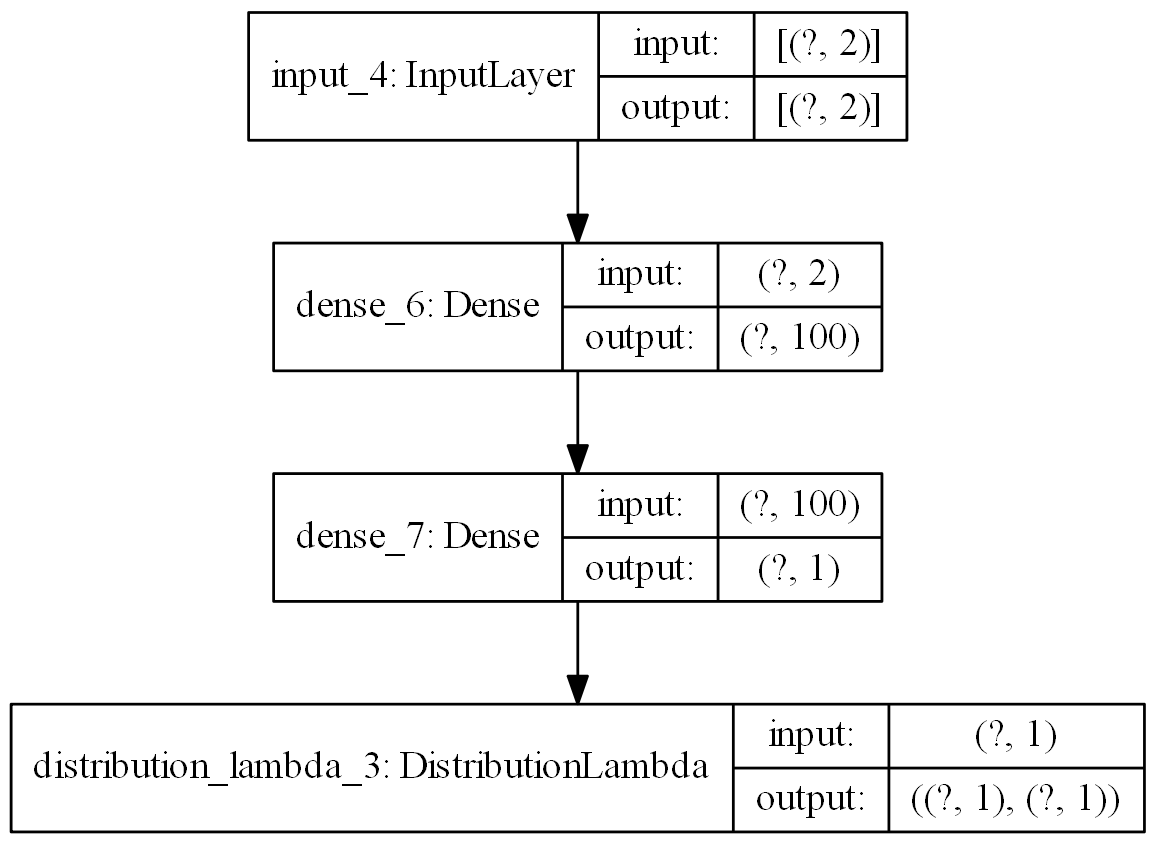

In [61]:
# Print network flow chart
keras.utils.plot_model(modelPnnFatigue, to_file='model.png', show_shapes=True, show_layer_names=True,
                       rankdir='TB', expand_nested=False, dpi=200)

## Model Training 

In [62]:
# Train the model for number of epochs
history = modelPnnFatigue.fit(X_train, Y_train, epochs=25000, verbose=0, validation_data=(X_valid,Y_valid), shuffle= True)
modelPnnFatigue = Model(inputs=inputs, outputs=dist.mean())

##  Loss Evaluation

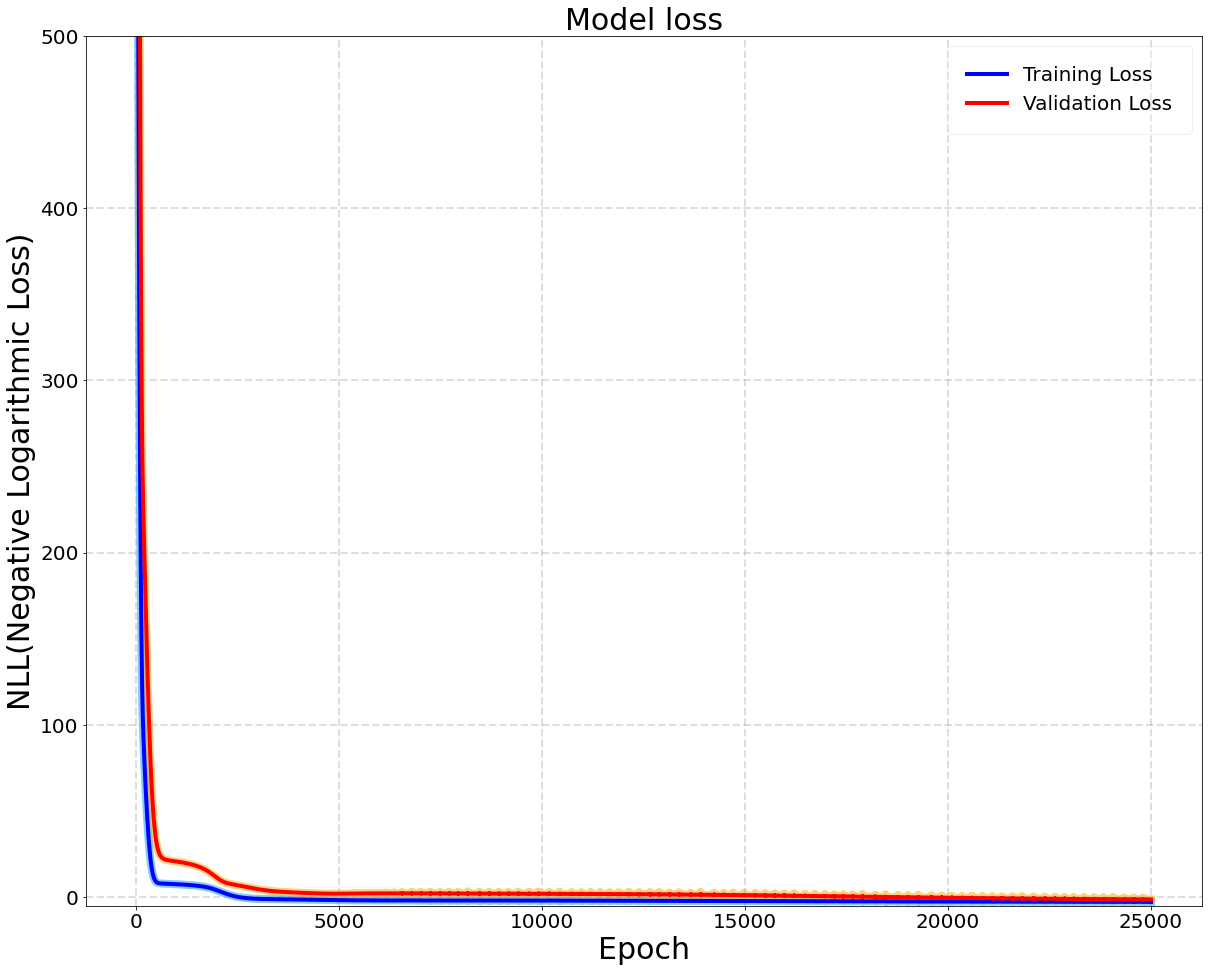

In [63]:
# Evalute netwroks training performance
df = pd.DataFrame(history.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()

plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')

plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(-5,500)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

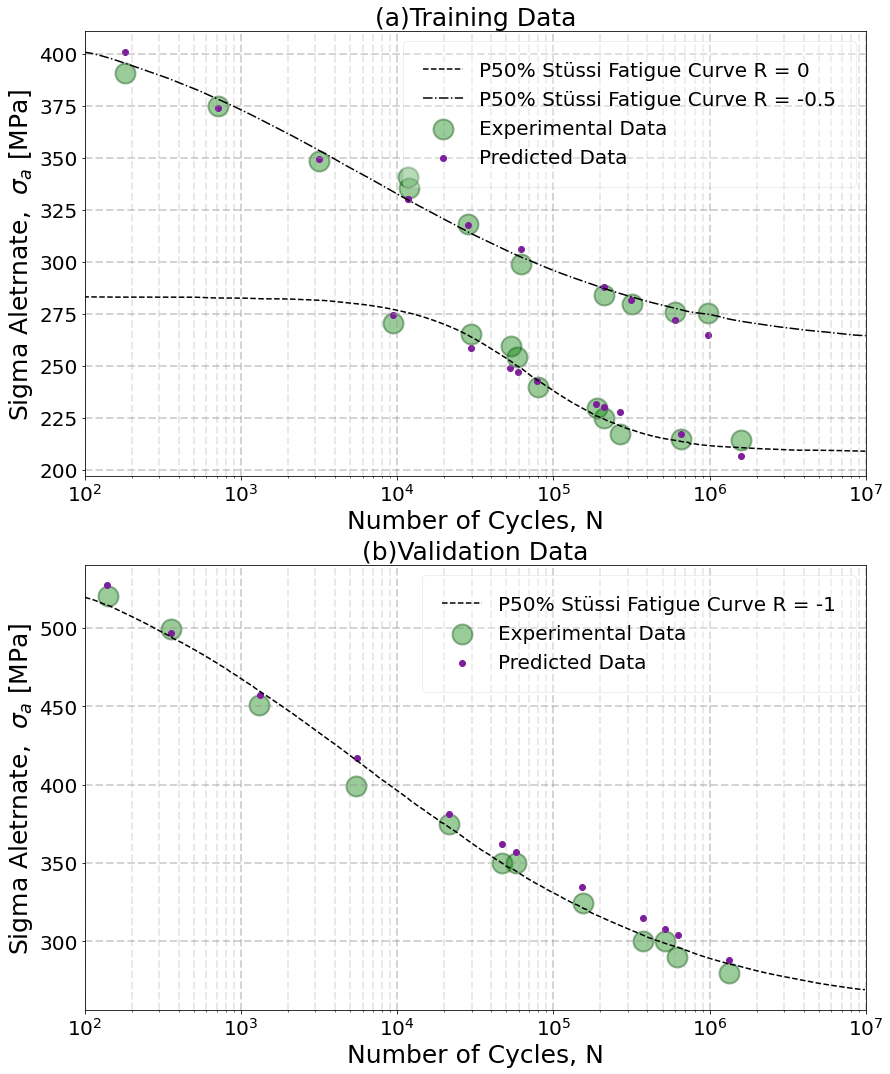

In [64]:
# Create figure
plt.figure(figsize=(14,18))
# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnFatigue.predict(X_train)
plt.scatter(np.power(10,[ExpX_train["nNormalized"][1:]*7]),ExpY_train[1:]*568/2,color="#008000",
            alpha = 0.4,s=400,linewidth=2, edgecolors="#054907",label = 'Experimental Data')
plt.scatter(np.power(10,[X_train["nNormalized"][5:-2]*7]),preds[5:-2]*568/2,color="#7E1E9C",
            label = 'Predicted Data') #observerd 
plt.plot( np.power(10,np.array ( X_train_P50[:600]).reshape([-1,1]) * 7), Y_train_P50[:600]*568/2,color="black",
         linestyle='--',label = 'P50% Stüssi Fatigue Curve R = 0')
plt.plot( np.power(10,np.array ( X_train_P50[600:]).reshape([-1,1]) * 7), Y_train_P50[600:]*568/2,color="black",
         linestyle='-.',label = 'P50% Stüssi Fatigue Curve R = -0.5')
plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.xlim([100,10000000])
plt.xscale('log')



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnFatigue.predict(X_valid)
plt.scatter(np.power(10,[ExpX_valid["nNormalized"]*7]),ExpY_valid*568/2,color="#008000",
            alpha = 0.4,s=400,linewidth=2, label = 'Experimental Data',edgecolors="#054907",)
plt.scatter(np.power(10,[X_valid["nNormalized"]*7]),preds*568/2,color="#7E1E9C",label = 'Predicted Data') #observerd 
plt.plot( np.power(10,np.array (X_valid_P50).reshape([-1,1]) * 7),Y_valid_P50*568/2,color="black",
         linestyle='--',label = 'P50% Stüssi Fatigue Curve R = -1')
plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(b)Validation Data", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.xlim([100,10000000])
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()





# Calculate correaltion factor for training and validation data

In [65]:
# Training data correaltion
preds =  modelPnnFatigue.predict(X_train)
train_corr = scipy.stats.pearsonr(np.array(preds*568/2).reshape([-1]), np.array(Y_train['Target'],dtype= np.float32)*568/2)
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  modelPnnFatigue.predict(X_valid)
val_corr = scipy.stats.pearsonr(np.array(preds*568/2).reshape([-1]), np.array(Y_valid['Target'], dtype= np.float32)*568/2)
print ('Validation Person correlation is  ', val_corr)

# Training and validation error 
from sklearn.metrics import mean_squared_error
preds = modelPnnFatigue.predict(X_train)
print('Prediction error of Training Data',mean_squared_error(preds ,Y_train)/2)
preds = modelPnnFatigue.predict(X_valid)
print('Prediction error of validation Data',mean_squared_error(preds , Y_valid)/2)

Training Person correlation is   (0.999323002898109, 7.937041330905825e-39)
Validation Person correlation is   (0.9980456062459654, 2.2381836988640767e-13)
Prediction error of Training Data 0.00011224194586870432
Prediction error of validation Data 0.0005198616985501728


# Plot real data vs predicted data

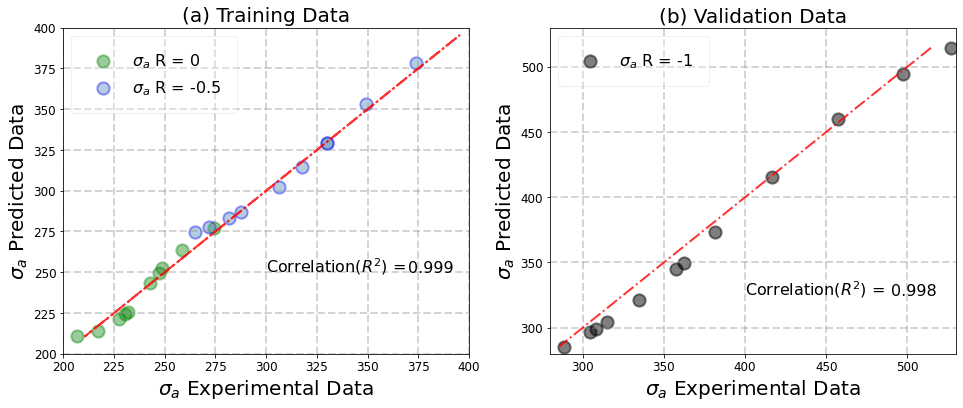

In [66]:

plt.figure(figsize=(16,6))

# Subplot1 training data
plt.subplot(1,2,1)
preds =  modelPnnFatigue.predict(X_train)
plt.plot(Y_train[5:-3]*568/2,Y_train[5:-3]*568/2,color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(preds[0+5:11+4]*568/2,Y_train[0+5:11+4]*568/2,color="green",edgecolors="green", s =150,
            alpha = 0.4,linewidth=2, label = ( r'$σ_{a}$' ' R = 0')) #observerd 
plt.scatter(preds[12+4:-2]*568/2,Y_train[12+4:-2]*568/2,color="steelblue",edgecolors="#0000FF", s =150,
            alpha = 0.4,linewidth=2,label = ( r'$σ_{a}$' ' R = -0.5')) #observerd 
plt.xlabel(( r'$σ_{a}$' ' Experimental Data'),size=20)
plt.ylabel(( r'$σ_{a}$' ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1)
plt.title("(a) Training Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlim([200,400])
plt.ylim([200,400])
plt.text(300, 250, ('Correlation' r'$(R^{2}$' ') = '), fontsize = 16)
plt.text(370, 250, round (train_corr[0],3) , fontsize = 16)

# subplot2 validation data
plt.subplot(1,2,2)
preds =  modelPnnFatigue.predict(X_valid)
plt.plot(Y_valid[2:]*568/2,Y_valid[2:]*568/2,color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(preds*568/2,Y_valid*568/2,color="black",edgecolors="black", s =150,alpha = 0.5,linewidth=2,
            label = ( r'$σ_{a}$' ' R = -1')) #observerd 
plt.xlabel(( r'$σ_{a}$' ' Experimental Data'),size=20)
plt.ylabel(( r'$σ_{a}$' ' Predicted Data'),size=20)
plt.title("(b) Validation Data", size = 20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlim([280,530])
plt.ylim([280,530])
plt.text(400, 325, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(490, 325, round (val_corr[0],3) , fontsize = 16)
plt.show()

# Probabilistic S-N curve base on PNN prediction 

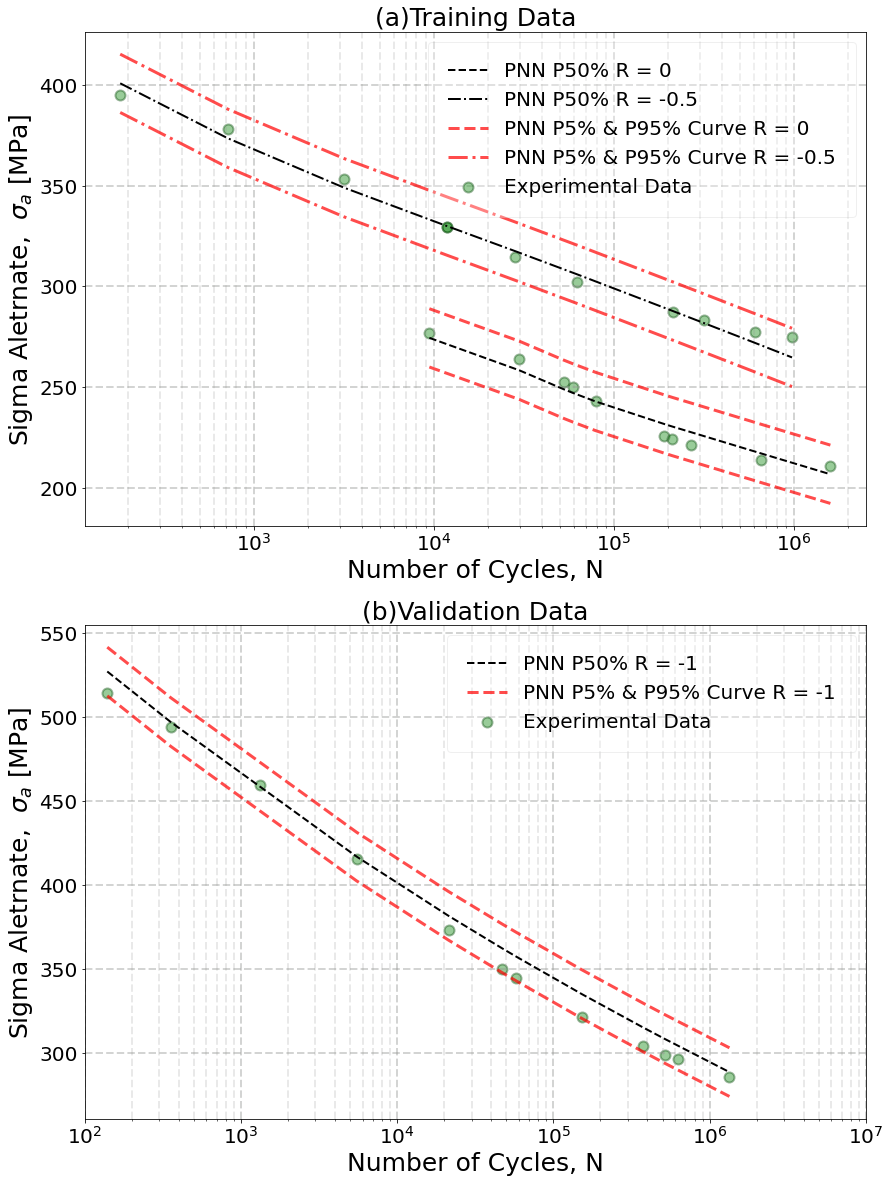

In [67]:
# get uncertainty model
modelPnnFatigue_sd = Model(inputs=inputs, outputs=dist.stddev())
# Create prediction graph
plt.figure(figsize=(14,20))

# Subplot1 training data
plt.subplot(2,1,1)

preds = modelPnnFatigue.predict(X_train)

plt.scatter(np.power(10,[X_train["nNormalized"][5:-2]*7]),Y_train[5:-2]*568/2,color="#008000",
            alpha = 0.4,s=100,linewidth=2, edgecolors="#054907",label = 'Experimental Data')

plt.plot((np.power(10,[X_train["nNormalized"][5:11+4]*7])).reshape([-1,1]),np.array(preds[5:11+4]*568/2).reshape([-1,1]),
         color="black", alpha = 1,linestyle="--",linewidth=2,label = 'PNN P50% R = 0')

plt.plot((np.power(10,[X_train["nNormalized"][11+4:-2]*7])).reshape([-1,1]),np.array(preds[11+4:-2]*568/2).reshape([-1,1]),
          color="black", alpha = 1,linewidth=2,linestyle="-.",label = 'PNN P50% R = -0.5')

plt.plot(np.power(10,np.array (X_train["nNormalized"][5:11+4]).reshape([-1,1]) * 7),
          (preds[5:11+4] +3*modelPnnFatigue_sd.predict(X_train)[5:11+4])*284,color="red",linestyle="--",alpha =0.7, linewidth=3)

plt.plot(np.power(10,np.array (X_train["nNormalized"][5:11+4]).reshape([-1,1]) * 7),
          (preds[5:11+4] -3*modelPnnFatigue_sd.predict(X_train)[5:11+4])*284,color="red",
          linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P5% & P95% Curve R = 0')

plt.plot(np.power(10,np.array (X_train["nNormalized"][11+4:-2]).reshape([-1,1]) * 7),
          (preds[11+4:-2] -3*modelPnnFatigue_sd.predict(X_train)[11+4:-2])*284,color="red",
          linestyle="-.",alpha  = 0.7,linewidth=3,label = 'PNN P5% & P95% Curve R = -0.5')

plt.plot(np.power(10,np.array (X_train["nNormalized"][11+4:-2]).reshape([-1,1]) * 7),
          (preds[11+4:-2] +3*modelPnnFatigue_sd.predict(X_train)[11+4:-2])*284,color="red",
          linestyle="-.",alpha  = 0.7,linewidth=3) 

plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.xscale('log')



# Subplot2 validation data

plt.subplot(2,1,2)
preds = modelPnnFatigue.predict(X_valid)

plt.scatter(np.power(10,[X_valid["nNormalized"]*7]),Y_valid*568/2,color="#008000",
            alpha = 0.4,s=100,linewidth=2, label = 'Experimental Data',edgecolors="#054907",)

plt.plot((np.power(10,[X_valid["nNormalized"][2:]*7])).reshape([-1,1]),np.array(preds[2:]*568/2).reshape([-1,1]),
         color="black", alpha = 1,linestyle="--",linewidth=2,label = 'PNN P50% R = -1')

plt.plot(np.power(10,np.array (X_valid["nNormalized"][2:]).reshape([-1,1]) * 7),
         (preds[2:] +3*modelPnnFatigue_sd.predict(X_valid)[2:])*284,color="red",linestyle="--",alpha =0.7, linewidth=3)

plt.plot(np.power(10,np.array (X_valid["nNormalized"][2:]).reshape([-1,1]) * 7),
         (preds[2:] -3*modelPnnFatigue_sd.predict(X_valid)[2:])*284,color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P5% & P95% Curve R = -1')


plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(b)Validation Data", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.xlim([100,10000000])
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Artificial constant life diagram for fatigue data by PNN algorithm: failure probability of 50%.

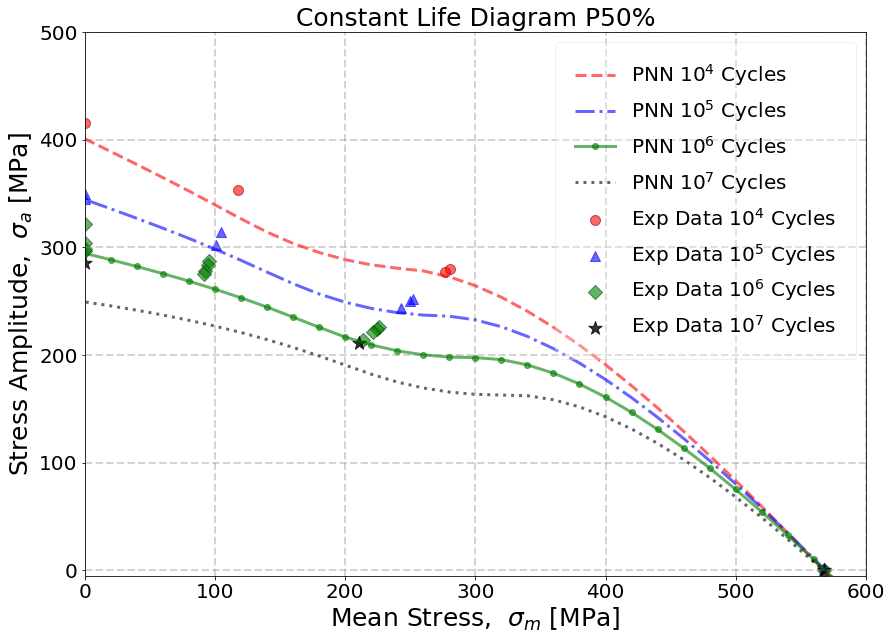

In [68]:
# generate sigma M data
sigmaM =np.arange(-1000,2000,20, dtype = float)
sigmaM_nor = sigmaM/568 # normalize sigmaM

# generate 10^4 cycles data
N104= np.ones(150)*10000.0
N104_nor = np.log10( N104 )/7
test_data104 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N104_nor})
preds104 = modelPnnFatigue.predict(test_data104)

# generate 10^5 cycles data
N105= np.ones(150)*100000.0
N105_nor = np.log10( N105 )/7
test_data105 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N105_nor})
preds105 = modelPnnFatigue.predict(test_data105)

# generate 10^6 cycles data
N106= np.ones(150)*1000000.0
N106_nor = np.log10( N106 )/7
test_data106 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N106_nor})
preds106 = modelPnnFatigue.predict(test_data106)

# generate 10^7 cycles data
N107= np.ones(150)*10000000.0
N107_nor = np.log10( N107 )/7
test_data107 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N107_nor})
preds107 = modelPnnFatigue.predict(test_data107)

# Process all data to create CLD graph with Exp data
Alldata_train = [X_train[:], X_valid[3:]]
Alldata_train = pd.concat(Alldata_train).reset_index(drop=True)
Alldata_valid = [Y_train[:], Y_valid[3:]]
Alldata_valid = pd.concat(Alldata_valid).reset_index(drop=True)
Alldata = [Alldata_train,Alldata_valid]
Alldata = pd.concat(Alldata , axis= 1)
Alldata['sigmaMean'] = Alldata['sigmaMeanNormalized']*568
Alldata['N'] = 10**(Alldata['nNormalized']*7)
Alldata['sigmaA'] = Alldata['Target']*284
AllExp104 = Alldata[(Alldata['N']>1000) & (Alldata['N']<10000)]
AllExp104.drop([26], inplace= True)
AllExp105 = Alldata[(Alldata['N']>10000) & (Alldata['N']<100000)]
AllExp105.drop([6,18,19,30], inplace= True)
AllExp106 = Alldata[(Alldata['N']>100000) & (Alldata['N']<1000000)]
AllExp107 = Alldata[(Alldata['N']>1000000)]

# Plot resulted CLD

#create figure
plt.figure(figsize=(14,10))

plt.plot(test_data104['sigmaMeanNormalized']*568,preds104*284,color="red",
            alpha = 0.6,linewidth=3, linestyle='--',label = ('PNN '  r'$10^{4}$' ' Cycles'))
plt.plot(test_data105['sigmaMeanNormalized']*568,preds105*284,color="blue",
            alpha = 0.6,linewidth=3,linestyle='-.',label = ('PNN '  r'$10^{5}$' ' Cycles'))
plt.plot(test_data106['sigmaMeanNormalized']*568,preds106*284,'go-',
            alpha = 0.6,linewidth=3, label = ('PNN '  r'$10^{6}$' ' Cycles'))
plt.plot(test_data107['sigmaMeanNormalized']*568,preds107*284,color="black",
            alpha = 0.6,linewidth=3,linestyle=':',label = ('PNN '  r'$10^{7}$' ' Cycles'))
plt.scatter(AllExp104['sigmaMean'], AllExp104['sigmaA'],color="red",
            alpha = 0.6,s=100,linewidth=1, label = ('Exp Data '  r'$10^{4}$' ' Cycles'),edgecolors="#8c000f")
plt.scatter(AllExp105['sigmaMean'], AllExp105['sigmaA'],color="blue",
            alpha = 0.6,s=100,linewidth=1,  marker='^',label = ('Exp Data '  r'$10^{5}$' ' Cycles'),edgecolors="#0000ff")
plt.scatter(AllExp106['sigmaMean'], AllExp106['sigmaA'],color="green",
            alpha = 0.6,s=100,linewidth=1,  marker='D',label = ('Exp Data '  r'$10^{6}$' ' Cycles'),edgecolors="#054907")
plt.scatter(AllExp107['sigmaMean'], AllExp107['sigmaA'] ,color="black",
            alpha = 0.8,s=200,linewidth=1,  marker='*',label = ('Exp Data '  r'$10^{7}$' ' Cycles'),edgecolors="black")

plt.xlabel(('Mean Stress,  ' r'$σ_{m}$' ' [MPa]'),size=25)
plt.ylabel(('Stress Amplitude,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("Constant Life Diagram P50%", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim ([-5,500])
plt.xlim ([0,600])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)


# Combined P50% and P5% ANN

## Import Data

In [30]:
# Read data from files 
# get data from csv file

# get experimental data
ExpData= pd.read_csv('Experimental Data.csv')
# split traing and valiating data
ExpX_train = ExpData[['sigmaMeanNormalized' ,'nNormalized']][:22]
ExpX_valid = ExpData[['sigmaMeanNormalized' ,'nNormalized']][22:]
ExpY_train = ExpData[['Target']][:22]
ExpY_valid = ExpData[['Target']][22:]

# # get P50% & P5% Stussi data
# get P50% curve
Data = pd.read_csv('StussP50.csv')
X_train_P50_HR = Data['nNormalized'][0:1200]
X_valid_P50_HR = Data['nNormalized'][1200:]
Y_train_P50_HR = Data[['Target']][0:1200]
Y_valid_P50_HR = Data[['Target']][1200:]

# get P50% & P5% Stussi data
# get P50% 
DataP50 = pd.read_csv('P50Data.csv')
X_train_P50 = [DataP50[['sigmaMeanNormalized' ,'nNormalized']][:26],
               DataP50[['sigmaMeanNormalized' ,'nNormalized']].iloc[[27,32]]]
X_train_P50 = pd.concat(X_train_P50).reset_index(drop=True)
X_valid_P50 = DataP50[['sigmaMeanNormalized' ,'nNormalized']][26:]
X_valid_P50 = X_valid_P50.reset_index(drop=True)
Y_train_P50 = [DataP50[['Target']][:26],DataP50[['Target']].iloc[[27,32]]]
Y_train_P50 = pd.concat(Y_train_P50).reset_index(drop=True)
Y_valid_P50 = DataP50[['Target']][26:].reset_index(drop=True)

# get P5%
DataP5 = pd.read_csv('P5Data.csv')
X_train_P5 = [DataP5[['sigmaMeanNormalized' ,'nNormalized']][:26],
               DataP5[['sigmaMeanNormalized' ,'nNormalized']].iloc[[27,32]]]
X_train_P5 = pd.concat(X_train_P5).reset_index(drop=True)
X_valid_P5 = DataP50[['sigmaMeanNormalized' ,'nNormalized']][26:]
X_valid_P5 = X_valid_P5.reset_index(drop=True)
Y_train_P5 = [DataP5[['Target']][:26],DataP5[['Target']].iloc[[27,32]]]
Y_train_P5 = pd.concat(Y_train_P5).reset_index(drop=True)
Y_valid_P5 = DataP5[['Target']][26:].reset_index(drop=True)

# Sort out input_A data which related to P50% data
X1_train = X_train_P50
X1_valid = X_valid_P50
Y1_train = Y_train_P50
Y1_valid = Y_valid_P50

# Sort out input_B data which related to P5% data
X2_train = X_train_P5
X2_valid = X_valid_P5
Y2_train = Y_train_P5
Y2_valid = Y_valid_P5

# Create ANN 

In [20]:
# Create combined network
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

input_A = keras.layers.Input(shape=(2,))
input_B = keras.layers.Input(shape=(2,))
hidden1 = keras.layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(input_A)
hidden2 = keras.layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(input_B)
output = keras.layers.Dense(1)(hidden1)
aux_output = keras.layers.Dense(1)(hidden2)
Conc = Concatenate()([output,aux_output])
params =keras.layers.Dense(2)(Conc)
combinedANNmodel = keras.models.Model(inputs=[input_A, input_B],
                           outputs= params) 
combinedANNmodel.compile(loss="mse",  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5))




## Model Summary

In [21]:
combinedANNmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 100)          300         input_5[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 100)          300         input_6[0][0]                    
____________________________________________________________________________________________

## Model Flow Chart

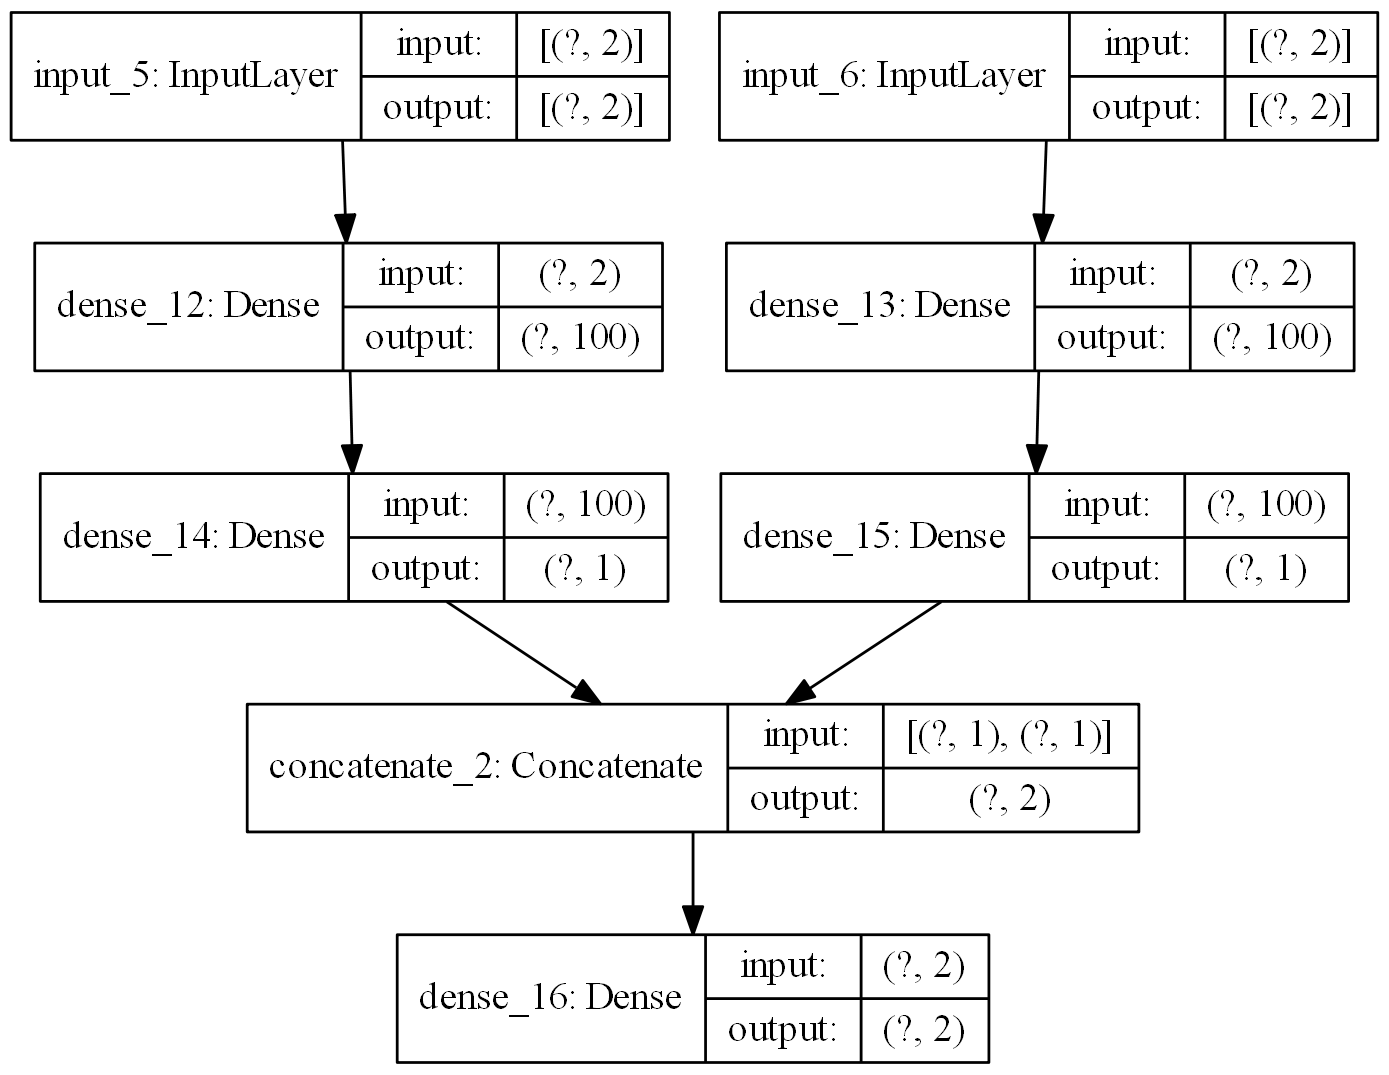

In [22]:
keras.utils.plot_model(combinedANNmodel, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=200
)

## Model Training 

In [23]:
history = combinedANNmodel.fit([X1_train, X1_train],np.concatenate((Y1_train, Y1_train), axis=1), epochs=12000,
                    validation_data=([X1_valid, X1_valid],np.concatenate((Y1_valid, Y1_valid), axis=1)), shuffle= True)

Train on 28 samples, validate on 12 samples
Epoch 1/15000
28/28 [==============================] - 0s 16ms/sample - loss: 1.1904 - val_loss: 1.8768
Epoch 2/15000
28/28 [==============================] - 0s 357us/sample - loss: 1.1560 - val_loss: 1.8374
Epoch 3/15000
28/28 [==============================] - 0s 322us/sample - loss: 1.1225 - val_loss: 1.7990
Epoch 4/15000
28/28 [==============================] - 0s 286us/sample - loss: 1.0898 - val_loss: 1.7615
Epoch 5/15000
28/28 [==============================] - 0s 357us/sample - loss: 1.0580 - val_loss: 1.7248
Epoch 6/15000
28/28 [==============================] - 0s 249us/sample - loss: 1.0271 - val_loss: 1.6892
Epoch 7/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.9970 - val_loss: 1.6543
Epoch 8/15000
28/28 [==============================] - 0s 392us/sample - loss: 0.9679 - val_loss: 1.6201
Epoch 9/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.9396 - val_loss: 1.5864
Epoch 10/150

Epoch 78/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.2457 - val_loss: 0.4848
Epoch 79/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.2426 - val_loss: 0.4789
Epoch 80/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.2395 - val_loss: 0.4731
Epoch 81/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.2364 - val_loss: 0.4674
Epoch 82/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.2334 - val_loss: 0.4618
Epoch 83/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.2305 - val_loss: 0.4563
Epoch 84/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.2276 - val_loss: 0.4509
Epoch 85/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.2248 - val_loss: 0.4457
Epoch 86/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.2221 - val_loss: 0.4405
Epoch 87/15000
28/28 [========================

Epoch 155/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.1192 - val_loss: 0.2420
Epoch 156/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.1183 - val_loss: 0.2404
Epoch 157/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.1175 - val_loss: 0.2389
Epoch 158/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.1166 - val_loss: 0.2374
Epoch 159/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.1158 - val_loss: 0.2359
Epoch 160/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.1150 - val_loss: 0.2344
Epoch 161/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.1142 - val_loss: 0.2329
Epoch 162/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.1134 - val_loss: 0.2315
Epoch 163/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.1126 - val_loss: 0.2300
Epoch 164/15000
28/28 [==============

Epoch 232/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0716 - val_loss: 0.1500
Epoch 233/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0712 - val_loss: 0.1490
Epoch 234/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0707 - val_loss: 0.1480
Epoch 235/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0703 - val_loss: 0.1471
Epoch 236/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0698 - val_loss: 0.1461
Epoch 237/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0694 - val_loss: 0.1451
Epoch 238/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0690 - val_loss: 0.1442
Epoch 239/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0685 - val_loss: 0.1432
Epoch 240/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0681 - val_loss: 0.1423
Epoch 241/15000
28/28 [==============

Epoch 309/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0463 - val_loss: 0.0941
Epoch 310/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0461 - val_loss: 0.0935
Epoch 311/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0458 - val_loss: 0.0930
Epoch 312/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0456 - val_loss: 0.0925
Epoch 313/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0454 - val_loss: 0.0920
Epoch 314/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0452 - val_loss: 0.0914
Epoch 315/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0450 - val_loss: 0.0910
Epoch 316/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0448 - val_loss: 0.0905
Epoch 317/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0446 - val_loss: 0.0900
Epoch 318/15000
28/28 [==============

Epoch 386/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0337 - val_loss: 0.0632
Epoch 387/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0336 - val_loss: 0.0629
Epoch 388/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0334 - val_loss: 0.0626
Epoch 389/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0333 - val_loss: 0.0623
Epoch 390/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0332 - val_loss: 0.0620
Epoch 391/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0331 - val_loss: 0.0617
Epoch 392/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0330 - val_loss: 0.0614
Epoch 393/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0328 - val_loss: 0.0612
Epoch 394/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0327 - val_loss: 0.0609
Epoch 395/15000
28/28 [==============

Epoch 463/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0257 - val_loss: 0.0421
Epoch 464/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0256 - val_loss: 0.0420
Epoch 465/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0255 - val_loss: 0.0418
Epoch 466/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0255 - val_loss: 0.0416
Epoch 467/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0254 - val_loss: 0.0415
Epoch 468/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0253 - val_loss: 0.0414
Epoch 469/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0252 - val_loss: 0.0412
Epoch 470/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0252 - val_loss: 0.0411
Epoch 471/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0251 - val_loss: 0.0409
Epoch 472/15000
28/28 [==============

Epoch 540/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0211 - val_loss: 0.0344
Epoch 541/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0210 - val_loss: 0.0342
Epoch 542/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0210 - val_loss: 0.0341
Epoch 543/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0209 - val_loss: 0.0341
Epoch 544/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0209 - val_loss: 0.0340
Epoch 545/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0208 - val_loss: 0.0340
Epoch 546/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0208 - val_loss: 0.0338
Epoch 547/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0207 - val_loss: 0.0337
Epoch 548/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0207 - val_loss: 0.0337
Epoch 549/15000
28/28 [==============

Epoch 617/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0177 - val_loss: 0.0296
Epoch 618/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0177 - val_loss: 0.0296
Epoch 619/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0177 - val_loss: 0.0296
Epoch 620/15000
28/28 [==============================] - 0s 2ms/sample - loss: 0.0176 - val_loss: 0.0297
Epoch 621/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0176 - val_loss: 0.0293
Epoch 622/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0176 - val_loss: 0.0296
Epoch 623/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0175 - val_loss: 0.0294
Epoch 624/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0175 - val_loss: 0.0293
Epoch 625/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0175 - val_loss: 0.0295
Epoch 626/15000
28/28 [================

Epoch 694/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0153 - val_loss: 0.0264
Epoch 695/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0153 - val_loss: 0.0261
Epoch 696/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0153 - val_loss: 0.0263
Epoch 697/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0152 - val_loss: 0.0261
Epoch 698/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0152 - val_loss: 0.0262
Epoch 699/15000
28/28 [==============================] - 0s 928us/sample - loss: 0.0152 - val_loss: 0.0262
Epoch 700/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0152 - val_loss: 0.0259
Epoch 701/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0151 - val_loss: 0.0261
Epoch 702/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0151 - val_loss: 0.0258
Epoch 703/15000
28/28 [==============

Epoch 771/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0135 - val_loss: 0.0238
Epoch 772/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0135 - val_loss: 0.0236
Epoch 773/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0135 - val_loss: 0.0237
Epoch 774/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0134 - val_loss: 0.0239
Epoch 775/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0134 - val_loss: 0.0233
Epoch 776/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0134 - val_loss: 0.0239
Epoch 777/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0134 - val_loss: 0.0232
Epoch 778/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0134 - val_loss: 0.0237
Epoch 779/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0133 - val_loss: 0.0233
Epoch 780/15000
28/28 [==============

Epoch 848/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0121 - val_loss: 0.0216
Epoch 849/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0121 - val_loss: 0.0219
Epoch 850/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0121 - val_loss: 0.0215
Epoch 851/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0121 - val_loss: 0.0218
Epoch 852/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0121 - val_loss: 0.0215
Epoch 853/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0120 - val_loss: 0.0220
Epoch 854/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0120 - val_loss: 0.0212
Epoch 855/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0120 - val_loss: 0.0219
Epoch 856/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0120 - val_loss: 0.0212
Epoch 857/15000
28/28 [==============

Epoch 925/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0110 - val_loss: 0.0201
Epoch 926/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0110 - val_loss: 0.0201
Epoch 927/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0110 - val_loss: 0.0202
Epoch 928/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0110 - val_loss: 0.0200
Epoch 929/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0110 - val_loss: 0.0201
Epoch 930/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0110 - val_loss: 0.0200
Epoch 931/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0110 - val_loss: 0.0201
Epoch 932/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0110 - val_loss: 0.0201
Epoch 933/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0109 - val_loss: 0.0199
Epoch 934/15000
28/28 [==============

Epoch 1002/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0102 - val_loss: 0.0187
Epoch 1003/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0102 - val_loss: 0.0189
Epoch 1004/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0102 - val_loss: 0.0188
Epoch 1005/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0102 - val_loss: 0.0188
Epoch 1006/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0102 - val_loss: 0.0191
Epoch 1007/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0102 - val_loss: 0.0185
Epoch 1008/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0101 - val_loss: 0.0191
Epoch 1009/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0101 - val_loss: 0.0185
Epoch 1010/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0101 - val_loss: 0.0190
Epoch 1011/15000
28/28 [====

Epoch 1078/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0095 - val_loss: 0.0175
Epoch 1079/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0095 - val_loss: 0.0181
Epoch 1080/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0095 - val_loss: 0.0175
Epoch 1081/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0095 - val_loss: 0.0182
Epoch 1082/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0095 - val_loss: 0.0173
Epoch 1083/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0095 - val_loss: 0.0182
Epoch 1084/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0095 - val_loss: 0.0173
Epoch 1085/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0095 - val_loss: 0.0181
Epoch 1086/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0095 - val_loss: 0.0174
Epoch 1087/15000
28/28 [====

Epoch 1154/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0090 - val_loss: 0.0167
Epoch 1155/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0090 - val_loss: 0.0173
Epoch 1156/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0090 - val_loss: 0.0167
Epoch 1157/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0089 - val_loss: 0.0174
Epoch 1158/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0090 - val_loss: 0.0166
Epoch 1159/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0090 - val_loss: 0.0174
Epoch 1160/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0089 - val_loss: 0.0165
Epoch 1161/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0089 - val_loss: 0.0173
Epoch 1162/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0089 - val_loss: 0.0166
Epoch 1163/15000
28/28 [====

Epoch 1230/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0085 - val_loss: 0.0159
Epoch 1231/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0085 - val_loss: 0.0167
Epoch 1232/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0085 - val_loss: 0.0160
Epoch 1233/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0085 - val_loss: 0.0167
Epoch 1234/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0085 - val_loss: 0.0159
Epoch 1235/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0085 - val_loss: 0.0168
Epoch 1236/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0085 - val_loss: 0.0159
Epoch 1237/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0085 - val_loss: 0.0166
Epoch 1238/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0085 - val_loss: 0.0159
Epoch 1239/15000
28/28 [====

Epoch 1306/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0081 - val_loss: 0.0154
Epoch 1307/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0081 - val_loss: 0.0163
Epoch 1308/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0081 - val_loss: 0.0153
Epoch 1309/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0081 - val_loss: 0.0162
Epoch 1310/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0081 - val_loss: 0.0153
Epoch 1311/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0081 - val_loss: 0.0161
Epoch 1312/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0081 - val_loss: 0.0154
Epoch 1313/15000
28/28 [==============================] - 0s 928us/sample - loss: 0.0081 - val_loss: 0.0162
Epoch 1314/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0081 - val_loss: 0.0153
Epoch 1315/15000
28/28 [====

Epoch 1382/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0078 - val_loss: 0.0148
Epoch 1383/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0078 - val_loss: 0.0156
Epoch 1384/15000
28/28 [==============================] - 0s 750us/sample - loss: 0.0078 - val_loss: 0.0149
Epoch 1385/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0077 - val_loss: 0.0157
Epoch 1386/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0078 - val_loss: 0.0148
Epoch 1387/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0078 - val_loss: 0.0157
Epoch 1388/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0077 - val_loss: 0.0148
Epoch 1389/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0077 - val_loss: 0.0156
Epoch 1390/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0077 - val_loss: 0.0148
Epoch 1391/15000
28/28 [====

Epoch 1458/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0075 - val_loss: 0.0143
Epoch 1459/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0075 - val_loss: 0.0153
Epoch 1460/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0075 - val_loss: 0.0143
Epoch 1461/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0075 - val_loss: 0.0152
Epoch 1462/15000
28/28 [==============================] - 0s 642us/sample - loss: 0.0074 - val_loss: 0.0144
Epoch 1463/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0074 - val_loss: 0.0153
Epoch 1464/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0075 - val_loss: 0.0143
Epoch 1465/15000
28/28 [==============================] - 0s 429us/sample - loss: 0.0075 - val_loss: 0.0153
Epoch 1466/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0074 - val_loss: 0.0143
Epoch 1467/15000
28/28 [====

Epoch 1534/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0072 - val_loss: 0.0140
Epoch 1535/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0072 - val_loss: 0.0148
Epoch 1536/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0072 - val_loss: 0.0140
Epoch 1537/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0072 - val_loss: 0.0149
Epoch 1538/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0072 - val_loss: 0.0140
Epoch 1539/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0072 - val_loss: 0.0149
Epoch 1540/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0072 - val_loss: 0.0140
Epoch 1541/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0072 - val_loss: 0.0149
Epoch 1542/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0072 - val_loss: 0.0139
Epoch 1543/15000
28/28 [====

Epoch 1610/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0070 - val_loss: 0.0136
Epoch 1611/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0069 - val_loss: 0.0146
Epoch 1612/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0070 - val_loss: 0.0136
Epoch 1613/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0070 - val_loss: 0.0146
Epoch 1614/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0069 - val_loss: 0.0136
Epoch 1615/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0069 - val_loss: 0.0145
Epoch 1616/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0069 - val_loss: 0.0136
Epoch 1617/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0069 - val_loss: 0.0145
Epoch 1618/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0069 - val_loss: 0.0135
Epoch 1619/15000
28/28 [====

Epoch 1686/15000
28/28 [==============================] - 0s 928us/sample - loss: 0.0067 - val_loss: 0.0132
Epoch 1687/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0067 - val_loss: 0.0142
Epoch 1688/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0067 - val_loss: 0.0133
Epoch 1689/15000
28/28 [==============================] - 0s 750us/sample - loss: 0.0067 - val_loss: 0.0142
Epoch 1690/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0067 - val_loss: 0.0132
Epoch 1691/15000
28/28 [==============================] - 0s 750us/sample - loss: 0.0067 - val_loss: 0.0142
Epoch 1692/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0067 - val_loss: 0.0132
Epoch 1693/15000
28/28 [==============================] - 0s 750us/sample - loss: 0.0067 - val_loss: 0.0143
Epoch 1694/15000
28/28 [==============================] - 0s 964us/sample - loss: 0.0067 - val_loss: 0.0132
Epoch 1695/15000
28/28 [====

Epoch 1762/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0065 - val_loss: 0.0129
Epoch 1763/15000
28/28 [==============================] - 0s 483us/sample - loss: 0.0065 - val_loss: 0.0139
Epoch 1764/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0065 - val_loss: 0.0129
Epoch 1765/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0065 - val_loss: 0.0139
Epoch 1766/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0065 - val_loss: 0.0129
Epoch 1767/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0065 - val_loss: 0.0139
Epoch 1768/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0065 - val_loss: 0.0130
Epoch 1769/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0065 - val_loss: 0.0139
Epoch 1770/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0065 - val_loss: 0.0129
Epoch 1771/15000
28/28 [====

Epoch 1838/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0063 - val_loss: 0.0127
Epoch 1839/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0063 - val_loss: 0.0136
Epoch 1840/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0063 - val_loss: 0.0126
Epoch 1841/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0063 - val_loss: 0.0136
Epoch 1842/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0063 - val_loss: 0.0126
Epoch 1843/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0063 - val_loss: 0.0136
Epoch 1844/15000
28/28 [==============================] - 0s 892us/sample - loss: 0.0063 - val_loss: 0.0126
Epoch 1845/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0063 - val_loss: 0.0136
Epoch 1846/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0063 - val_loss: 0.0126
Epoch 1847/15000
28/28 [====

Epoch 1914/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0062 - val_loss: 0.0123
Epoch 1915/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0062 - val_loss: 0.0134
Epoch 1916/15000
28/28 [==============================] - 0s 360us/sample - loss: 0.0062 - val_loss: 0.0123
Epoch 1917/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0061 - val_loss: 0.0133
Epoch 1918/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0061 - val_loss: 0.0124
Epoch 1919/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0061 - val_loss: 0.0134
Epoch 1920/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0061 - val_loss: 0.0123
Epoch 1921/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0061 - val_loss: 0.0133
Epoch 1922/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0061 - val_loss: 0.0124
Epoch 1923/15000
28/28 [====

Epoch 1990/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0059 - val_loss: 0.0127
Epoch 1991/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0059 - val_loss: 0.0124
Epoch 1992/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0059 - val_loss: 0.0127
Epoch 1993/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0059 - val_loss: 0.0123
Epoch 1994/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0059 - val_loss: 0.0126
Epoch 1995/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0059 - val_loss: 0.0124
Epoch 1996/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0059 - val_loss: 0.0127
Epoch 1997/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0059 - val_loss: 0.0124
Epoch 1998/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0059 - val_loss: 0.0126
Epoch 1999/15000
28/28 [====

Epoch 2066/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0058 - val_loss: 0.0119
Epoch 2067/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0058 - val_loss: 0.0128
Epoch 2068/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0058 - val_loss: 0.0118
Epoch 2069/15000
28/28 [==============================] - 0s 493us/sample - loss: 0.0058 - val_loss: 0.0128
Epoch 2070/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0058 - val_loss: 0.0118
Epoch 2071/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0058 - val_loss: 0.0128
Epoch 2072/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0058 - val_loss: 0.0119
Epoch 2073/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0058 - val_loss: 0.0128
Epoch 2074/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0058 - val_loss: 0.0118
Epoch 2075/15000
28/28 [====

Epoch 2142/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0057 - val_loss: 0.0116
Epoch 2143/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0057 - val_loss: 0.0126
Epoch 2144/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0057 - val_loss: 0.0116
Epoch 2145/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0057 - val_loss: 0.0126
Epoch 2146/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0057 - val_loss: 0.0116
Epoch 2147/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0057 - val_loss: 0.0126
Epoch 2148/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0057 - val_loss: 0.0116
Epoch 2149/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0057 - val_loss: 0.0126
Epoch 2150/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0057 - val_loss: 0.0116
Epoch 2151/15000
28/28 [====

Epoch 2218/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0056 - val_loss: 0.0114
Epoch 2219/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0055 - val_loss: 0.0124
Epoch 2220/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0055 - val_loss: 0.0114
Epoch 2221/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0055 - val_loss: 0.0124
Epoch 2222/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0055 - val_loss: 0.0114
Epoch 2223/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0055 - val_loss: 0.0124
Epoch 2224/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0055 - val_loss: 0.0114
Epoch 2225/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0055 - val_loss: 0.0124
Epoch 2226/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0055 - val_loss: 0.0113
Epoch 2227/15000
28/28 [====

Epoch 2294/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0054 - val_loss: 0.0112
Epoch 2295/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0054 - val_loss: 0.0122
Epoch 2296/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0054 - val_loss: 0.0111
Epoch 2297/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0054 - val_loss: 0.0122
Epoch 2298/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0054 - val_loss: 0.0112
Epoch 2299/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0054 - val_loss: 0.0122
Epoch 2300/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0054 - val_loss: 0.0111
Epoch 2301/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0054 - val_loss: 0.0122
Epoch 2302/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0054 - val_loss: 0.0111
Epoch 2303/15000
28/28 [====

Epoch 2370/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0053 - val_loss: 0.0110
Epoch 2371/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0053 - val_loss: 0.0118
Epoch 2372/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0052 - val_loss: 0.0110
Epoch 2373/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0052 - val_loss: 0.0121
Epoch 2374/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0053 - val_loss: 0.0108
Epoch 2375/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0054 - val_loss: 0.0127
Epoch 2376/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0056 - val_loss: 0.0106
Epoch 2377/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0058 - val_loss: 0.0131
Epoch 2378/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0059 - val_loss: 0.0106
Epoch 2379/15000
28/28 [====

Epoch 2446/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0051 - val_loss: 0.0109
Epoch 2447/15000
28/28 [==============================] - 0s 375us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2448/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0051 - val_loss: 0.0108
Epoch 2449/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2450/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0051 - val_loss: 0.0108
Epoch 2451/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2452/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0051 - val_loss: 0.0108
Epoch 2453/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2454/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0051 - val_loss: 0.0108
Epoch 2455/15000
28/28 [====

Epoch 2522/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0051 - val_loss: 0.0106
Epoch 2523/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2524/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0051 - val_loss: 0.0105
Epoch 2525/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2526/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0051 - val_loss: 0.0106
Epoch 2527/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2528/15000
28/28 [==============================] - 0s 518us/sample - loss: 0.0051 - val_loss: 0.0105
Epoch 2529/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0051 - val_loss: 0.0116
Epoch 2530/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0051 - val_loss: 0.0105
Epoch 2531/15000
28/28 [====

28/28 [==============================] - 0s 393us/sample - loss: 0.0050 - val_loss: 0.0104
Epoch 2599/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0050 - val_loss: 0.0114
Epoch 2600/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0049 - val_loss: 0.0104
Epoch 2601/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0049 - val_loss: 0.0113
Epoch 2602/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0049 - val_loss: 0.0104
Epoch 2603/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0049 - val_loss: 0.0113
Epoch 2604/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0049 - val_loss: 0.0104
Epoch 2605/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0049 - val_loss: 0.0114
Epoch 2606/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0050 - val_loss: 0.0104
Epoch 2607/15000
28/28 [=====================

28/28 [==============================] - 0s 518us/sample - loss: 0.0049 - val_loss: 0.0102
Epoch 2675/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0048 - val_loss: 0.0112
Epoch 2676/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0049 - val_loss: 0.0102
Epoch 2677/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0049 - val_loss: 0.0112
Epoch 2678/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0049 - val_loss: 0.0102
Epoch 2679/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0049 - val_loss: 0.0112
Epoch 2680/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0049 - val_loss: 0.0102
Epoch 2681/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0049 - val_loss: 0.0112
Epoch 2682/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0049 - val_loss: 0.0102
Epoch 2683/15000
28/28 [=====================

28/28 [==============================] - 0s 393us/sample - loss: 0.0048 - val_loss: 0.0101
Epoch 2751/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0048 - val_loss: 0.0111
Epoch 2752/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0048 - val_loss: 0.0101
Epoch 2753/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0048 - val_loss: 0.0111
Epoch 2754/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0048 - val_loss: 0.0101
Epoch 2755/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0048 - val_loss: 0.0111
Epoch 2756/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0048 - val_loss: 0.0101
Epoch 2757/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0048 - val_loss: 0.0110
Epoch 2758/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0048 - val_loss: 0.0101
Epoch 2759/15000
28/28 [=====================

28/28 [==============================] - 0s 321us/sample - loss: 0.0047 - val_loss: 0.0099
Epoch 2827/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0047 - val_loss: 0.0109
Epoch 2828/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0047 - val_loss: 0.0099
Epoch 2829/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0047 - val_loss: 0.0109
Epoch 2830/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0047 - val_loss: 0.0099
Epoch 2831/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0047 - val_loss: 0.0109
Epoch 2832/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0047 - val_loss: 0.0099
Epoch 2833/15000
28/28 [==============================] - 0s 388us/sample - loss: 0.0047 - val_loss: 0.0109
Epoch 2834/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0047 - val_loss: 0.0099
Epoch 2835/15000
28/28 [=====================

28/28 [==============================] - 0s 286us/sample - loss: 0.0045 - val_loss: 0.0099
Epoch 2903/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0045 - val_loss: 0.0104
Epoch 2904/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0045 - val_loss: 0.0100
Epoch 2905/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 2906/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0044 - val_loss: 0.0099
Epoch 2907/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 2908/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0044 - val_loss: 0.0100
Epoch 2909/15000
28/28 [==============================] - 0s 434us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 2910/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0044 - val_loss: 0.0100
Epoch 2911/15000
28/28 [=====================

28/28 [==============================] - 0s 464us/sample - loss: 0.0045 - val_loss: 0.0097
Epoch 2979/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0045 - val_loss: 0.0106
Epoch 2980/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0045 - val_loss: 0.0097
Epoch 2981/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0045 - val_loss: 0.0106
Epoch 2982/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0045 - val_loss: 0.0097
Epoch 2983/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0045 - val_loss: 0.0106
Epoch 2984/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0045 - val_loss: 0.0097
Epoch 2985/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0045 - val_loss: 0.0105
Epoch 2986/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0045 - val_loss: 0.0097
Epoch 2987/15000
28/28 [=====================

28/28 [==============================] - 0s 321us/sample - loss: 0.0044 - val_loss: 0.0096
Epoch 3055/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 3056/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0044 - val_loss: 0.0095
Epoch 3057/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 3058/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0044 - val_loss: 0.0096
Epoch 3059/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 3060/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0044 - val_loss: 0.0095
Epoch 3061/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0044 - val_loss: 0.0104
Epoch 3062/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0044 - val_loss: 0.0095
Epoch 3063/15000
28/28 [=====================

Epoch 3131/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0043 - val_loss: 0.0103
Epoch 3132/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0043 - val_loss: 0.0094
Epoch 3133/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0043 - val_loss: 0.0103
Epoch 3134/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0043 - val_loss: 0.0094
Epoch 3135/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0043 - val_loss: 0.0103
Epoch 3136/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0043 - val_loss: 0.0094
Epoch 3137/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0043 - val_loss: 0.0103
Epoch 3138/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0043 - val_loss: 0.0094
Epoch 3139/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0043 - val_loss: 0.0103
Epoch 3140/15000
28/28 [====

Epoch 3207/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0043 - val_loss: 0.0102
Epoch 3208/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0043 - val_loss: 0.0093
Epoch 3209/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0042 - val_loss: 0.0101
Epoch 3210/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0043 - val_loss: 0.0093
Epoch 3211/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0043 - val_loss: 0.0102
Epoch 3212/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0043 - val_loss: 0.0093
Epoch 3213/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0043 - val_loss: 0.0101
Epoch 3214/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0043 - val_loss: 0.0093
Epoch 3215/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0043 - val_loss: 0.0102
Epoch 3216/15000
28/28 [====

Epoch 3283/15000
28/28 [==============================] - 0s 964us/sample - loss: 0.0042 - val_loss: 0.0100
Epoch 3284/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0042 - val_loss: 0.0092
Epoch 3285/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0042 - val_loss: 0.0100
Epoch 3286/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0042 - val_loss: 0.0092
Epoch 3287/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0042 - val_loss: 0.0100
Epoch 3288/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0042 - val_loss: 0.0092
Epoch 3289/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0042 - val_loss: 0.0100
Epoch 3290/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0042 - val_loss: 0.0092
Epoch 3291/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0042 - val_loss: 0.0100
Epoch 3292/15000
28/28 [====

Epoch 3359/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0041 - val_loss: 0.0099
Epoch 3360/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0041 - val_loss: 0.0091
Epoch 3361/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0041 - val_loss: 0.0099
Epoch 3362/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0041 - val_loss: 0.0091
Epoch 3363/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0041 - val_loss: 0.0099
Epoch 3364/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0041 - val_loss: 0.0091
Epoch 3365/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0041 - val_loss: 0.0099
Epoch 3366/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0041 - val_loss: 0.0091
Epoch 3367/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0041 - val_loss: 0.0099
Epoch 3368/15000
28/28 [====

Epoch 3435/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0041 - val_loss: 0.0098
Epoch 3436/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0041 - val_loss: 0.0090
Epoch 3437/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0041 - val_loss: 0.0098
Epoch 3438/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0041 - val_loss: 0.0090
Epoch 3439/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0040 - val_loss: 0.0098
Epoch 3440/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0041 - val_loss: 0.0090
Epoch 3441/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0041 - val_loss: 0.0098
Epoch 3442/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0041 - val_loss: 0.0090
Epoch 3443/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0041 - val_loss: 0.0098
Epoch 3444/15000
28/28 [====

Epoch 3511/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0040 - val_loss: 0.0097
Epoch 3512/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0040 - val_loss: 0.0089
Epoch 3513/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0040 - val_loss: 0.0097
Epoch 3514/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0040 - val_loss: 0.0089
Epoch 3515/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0040 - val_loss: 0.0097
Epoch 3516/15000
28/28 [==============================] - 0s 467us/sample - loss: 0.0040 - val_loss: 0.0089
Epoch 3517/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0040 - val_loss: 0.0097
Epoch 3518/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0040 - val_loss: 0.0089
Epoch 3519/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0040 - val_loss: 0.0097
Epoch 3520/15000
28/28 [====

Epoch 3587/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0096
Epoch 3588/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0039 - val_loss: 0.0088
Epoch 3589/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0096
Epoch 3590/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0039 - val_loss: 0.0088
Epoch 3591/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0039 - val_loss: 0.0096
Epoch 3592/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0088
Epoch 3593/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0039 - val_loss: 0.0096
Epoch 3594/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0088
Epoch 3595/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0096
Epoch 3596/15000
28/28 [====

Epoch 3663/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0039 - val_loss: 0.0094
Epoch 3664/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0039 - val_loss: 0.0087
Epoch 3665/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0095
Epoch 3666/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0039 - val_loss: 0.0087
Epoch 3667/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0039 - val_loss: 0.0094
Epoch 3668/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0039 - val_loss: 0.0087
Epoch 3669/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0039 - val_loss: 0.0094
Epoch 3670/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0039 - val_loss: 0.0087
Epoch 3671/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0039 - val_loss: 0.0094
Epoch 3672/15000
28/28 [====

Epoch 3739/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0093
Epoch 3740/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0086
Epoch 3741/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0093
Epoch 3742/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0086
Epoch 3743/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0038 - val_loss: 0.0093
Epoch 3744/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0086
Epoch 3745/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0093
Epoch 3746/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0038 - val_loss: 0.0086
Epoch 3747/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0093
Epoch 3748/15000
28/28 [====

Epoch 3815/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0038 - val_loss: 0.0092
Epoch 3816/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0038 - val_loss: 0.0085
Epoch 3817/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0038 - val_loss: 0.0092
Epoch 3818/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0038 - val_loss: 0.0085
Epoch 3819/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0037 - val_loss: 0.0092
Epoch 3820/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0037 - val_loss: 0.0085
Epoch 3821/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0037 - val_loss: 0.0092
Epoch 3822/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0037 - val_loss: 0.0085
Epoch 3823/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0037 - val_loss: 0.0092
Epoch 3824/15000
28/28 [====

Epoch 3891/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0037 - val_loss: 0.0091
Epoch 3892/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0037 - val_loss: 0.0085
Epoch 3893/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0037 - val_loss: 0.0091
Epoch 3894/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0037 - val_loss: 0.0085
Epoch 3895/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0037 - val_loss: 0.0091
Epoch 3896/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0037 - val_loss: 0.0085
Epoch 3897/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0037 - val_loss: 0.0091
Epoch 3898/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0037 - val_loss: 0.0085
Epoch 3899/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0037 - val_loss: 0.0091
Epoch 3900/15000
28/28 [====

Epoch 3967/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0036 - val_loss: 0.0090
Epoch 3968/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0084
Epoch 3969/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0090
Epoch 3970/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0084
Epoch 3971/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0090
Epoch 3972/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0084
Epoch 3973/15000
28/28 [==============================] - 0s 295us/sample - loss: 0.0036 - val_loss: 0.0090
Epoch 3974/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0084
Epoch 3975/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0090
Epoch 3976/15000
28/28 [====

Epoch 4043/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4044/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0083
Epoch 4045/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4046/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0036 - val_loss: 0.0083
Epoch 4047/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4048/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0036 - val_loss: 0.0083
Epoch 4049/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4050/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0036 - val_loss: 0.0083
Epoch 4051/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4052/15000
28/28 [====

Epoch 4119/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4120/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0036 - val_loss: 0.0082
Epoch 4121/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4122/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0036 - val_loss: 0.0082
Epoch 4123/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4124/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0036 - val_loss: 0.0082
Epoch 4125/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4126/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0036 - val_loss: 0.0082
Epoch 4127/15000
28/28 [==============================] - 0s 2ms/sample - loss: 0.0036 - val_loss: 0.0089
Epoch 4128/15000
28/28 [======

Epoch 4195/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0035 - val_loss: 0.0087
Epoch 4196/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0035 - val_loss: 0.0082
Epoch 4197/15000
28/28 [==============================] - 0s 411us/sample - loss: 0.0035 - val_loss: 0.0087
Epoch 4198/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0035 - val_loss: 0.0082
Epoch 4199/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0035 - val_loss: 0.0087
Epoch 4200/15000
28/28 [==============================] - 0s 429us/sample - loss: 0.0035 - val_loss: 0.0082
Epoch 4201/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0035 - val_loss: 0.0088
Epoch 4202/15000
28/28 [==============================] - 0s 322us/sample - loss: 0.0035 - val_loss: 0.0082
Epoch 4203/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0035 - val_loss: 0.0088
Epoch 4204/15000
28/28 [====

Epoch 4271/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0035 - val_loss: 0.0087
Epoch 4272/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0034 - val_loss: 0.0081
Epoch 4273/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0086
Epoch 4274/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0081
Epoch 4275/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0034 - val_loss: 0.0086
Epoch 4276/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0081
Epoch 4277/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0034 - val_loss: 0.0087
Epoch 4278/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0035 - val_loss: 0.0081
Epoch 4279/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0035 - val_loss: 0.0087
Epoch 4280/15000
28/28 [====

Epoch 4347/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0086
Epoch 4348/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4349/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0034 - val_loss: 0.0086
Epoch 4350/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4351/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0085
Epoch 4352/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4353/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0034 - val_loss: 0.0086
Epoch 4354/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4355/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0034 - val_loss: 0.0086
Epoch 4356/15000
28/28 [====

Epoch 4423/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0085
Epoch 4424/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4425/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0034 - val_loss: 0.0085
Epoch 4426/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4427/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0085
Epoch 4428/15000
28/28 [==============================] - 0s 429us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4429/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0034 - val_loss: 0.0085
Epoch 4430/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0034 - val_loss: 0.0080
Epoch 4431/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0034 - val_loss: 0.0085
Epoch 4432/15000
28/28 [====

Epoch 4499/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4500/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4501/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4502/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4503/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4504/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4505/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4506/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4507/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4508/15000
28/28 [====

Epoch 4575/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4576/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4577/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0084
Epoch 4578/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4579/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4580/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4581/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4582/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0033 - val_loss: 0.0079
Epoch 4583/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4584/15000
28/28 [====

Epoch 4651/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4652/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0078
Epoch 4653/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4654/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0033 - val_loss: 0.0078
Epoch 4655/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4656/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0078
Epoch 4657/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4658/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0032 - val_loss: 0.0078
Epoch 4659/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0033 - val_loss: 0.0083
Epoch 4660/15000
28/28 [====

Epoch 4727/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4728/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4729/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4730/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4731/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4732/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4733/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4734/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4735/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4736/15000
28/28 [====

Epoch 4803/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4804/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4805/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0082
Epoch 4806/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4807/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0081
Epoch 4808/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4809/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0032 - val_loss: 0.0081
Epoch 4810/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0032 - val_loss: 0.0077
Epoch 4811/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4812/15000
28/28 [====

Epoch 4879/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4880/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0077
Epoch 4881/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4882/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 4883/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4884/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 4885/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4886/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0077
Epoch 4887/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4888/15000
28/28 [====

Epoch 4955/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4956/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 4957/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 4958/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 4959/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 4960/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 4961/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 4962/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 4963/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0081
Epoch 4964/15000
28/28 [====

Epoch 5031/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 5032/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 5033/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 5034/15000
28/28 [==============================] - 0s 554us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 5035/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 5036/15000
28/28 [==============================] - 0s 678us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 5037/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0080
Epoch 5038/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0076
Epoch 5039/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0079
Epoch 5040/15000
28/28 [====

Epoch 5107/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0031 - val_loss: 0.0079
Epoch 5108/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0075
Epoch 5109/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0031 - val_loss: 0.0079
Epoch 5110/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0031 - val_loss: 0.0075
Epoch 5111/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0031 - val_loss: 0.0079
Epoch 5112/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0031 - val_loss: 0.0075
Epoch 5113/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0031 - val_loss: 0.0079
Epoch 5114/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0030 - val_loss: 0.0075
Epoch 5115/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0030 - val_loss: 0.0079
Epoch 5116/15000
28/28 [====

Epoch 5183/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0079
Epoch 5184/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0030 - val_loss: 0.0075
Epoch 5185/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5186/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0075
Epoch 5187/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0079
Epoch 5188/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0030 - val_loss: 0.0075
Epoch 5189/15000
28/28 [==============================] - 0s 304us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5190/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0030 - val_loss: 0.0075
Epoch 5191/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5192/15000
28/28 [====

Epoch 5259/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5260/15000
28/28 [==============================] - 0s 537us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5261/15000
28/28 [==============================] - 0s 335us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5262/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5263/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5264/15000
28/28 [==============================] - 0s 678us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5265/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5266/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5267/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5268/15000
28/28 [====

Epoch 5335/15000
28/28 [==============================] - 0s 304us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5336/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5337/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5338/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5339/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5340/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5341/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0078
Epoch 5342/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0030 - val_loss: 0.0074
Epoch 5343/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5344/15000
28/28 [====

Epoch 5411/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5412/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0074
Epoch 5413/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5414/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0029 - val_loss: 0.0074
Epoch 5415/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0076
Epoch 5416/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5417/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5418/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0074
Epoch 5419/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5420/15000
28/28 [====

Epoch 5487/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0077
Epoch 5488/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5489/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5490/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5491/15000
28/28 [==============================] - 0s 317us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5492/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5493/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5494/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5495/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5496/15000
28/28 [====

Epoch 5563/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 5564/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0073
Epoch 5565/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0030 - val_loss: 0.0077
Epoch 5566/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0030 - val_loss: 0.0073
Epoch 5567/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0076
Epoch 5568/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5569/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0029 - val_loss: 0.0076
Epoch 5570/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5571/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0028 - val_loss: 0.0076
Epoch 5572/15000
28/28 [====

Epoch 5639/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0076
Epoch 5640/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0029 - val_loss: 0.0073
Epoch 5641/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0075
Epoch 5642/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5643/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5644/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5645/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5646/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5647/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5648/15000
28/28 [====

Epoch 5715/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5716/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5717/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5718/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5719/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5720/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5721/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 5722/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5723/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 5724/15000
28/28 [====

Epoch 5791/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0075
Epoch 5792/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5793/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 5794/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5795/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 5796/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5797/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 5798/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0072
Epoch 5799/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 5800/15000
28/28 [====

Epoch 5867/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0074
Epoch 5868/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 5869/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0074
Epoch 5870/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 5871/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0074
Epoch 5872/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 5873/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0074
Epoch 5874/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 5875/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0074
Epoch 5876/15000
28/28 [====

Epoch 5943/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0075
Epoch 5944/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0072
Epoch 5945/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0029 - val_loss: 0.0075
Epoch 5946/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0072
Epoch 5947/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0075
Epoch 5948/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0072
Epoch 5949/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0075
Epoch 5950/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0072
Epoch 5951/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0029 - val_loss: 0.0075
Epoch 5952/15000
28/28 [====

Epoch 6019/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6020/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 6021/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6022/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6023/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6024/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6025/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6026/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6027/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6028/15000
28/28 [====

Epoch 6095/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0073
Epoch 6096/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6097/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0073
Epoch 6098/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 6099/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0028 - val_loss: 0.0073
Epoch 6100/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 6101/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6102/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 6103/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6104/15000
28/28 [====

Epoch 6171/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6172/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6173/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6174/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0071
Epoch 6175/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6176/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6177/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6178/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6179/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6180/15000
28/28 [====

Epoch 6247/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6248/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6249/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6250/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6251/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6252/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0071
Epoch 6253/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0074
Epoch 6254/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0070
Epoch 6255/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0073
Epoch 6256/15000
28/28 [====

Epoch 6323/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6324/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6325/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0072
Epoch 6326/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6327/15000
28/28 [==============================] - 0s 643us/sample - loss: 0.0027 - val_loss: 0.0072
Epoch 6328/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6329/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0073
Epoch 6330/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6331/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0072
Epoch 6332/15000
28/28 [====

Epoch 6399/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6400/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6401/15000
28/28 [==============================] - 0s 429us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6402/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6403/15000
28/28 [==============================] - 0s 394us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6404/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6405/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6406/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6407/15000
28/28 [==============================] - 0s 465us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6408/15000
28/28 [====

Epoch 6475/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6476/15000
28/28 [==============================] - 0s 430us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6477/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6478/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6479/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6480/15000
28/28 [==============================] - 0s 322us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6481/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6482/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0070
Epoch 6483/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0027 - val_loss: 0.0072
Epoch 6484/15000
28/28 [====

Epoch 6551/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6552/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6553/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6554/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6555/15000
28/28 [==============================] - 0s 465us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6556/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6557/15000
28/28 [==============================] - 0s 429us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6558/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6559/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6560/15000
28/28 [====

Epoch 6627/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6628/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6629/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6630/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0069
Epoch 6631/15000
28/28 [==============================] - 0s 465us/sample - loss: 0.0026 - val_loss: 0.0072
Epoch 6632/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6633/15000
28/28 [==============================] - 0s 1ms/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6634/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6635/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6636/15000
28/28 [======

Epoch 6703/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6704/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6705/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6706/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6707/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6708/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6709/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6710/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6711/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6712/15000
28/28 [====

Epoch 6779/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6780/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6781/15000
28/28 [==============================] - 0s 322us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6782/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6783/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6784/15000
28/28 [==============================] - 0s 322us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6785/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6786/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6787/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6788/15000
28/28 [====

Epoch 6855/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6856/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6857/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6858/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6859/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6860/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6861/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6862/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6863/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 6864/15000
28/28 [====

Epoch 6931/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6932/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6933/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6934/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 6935/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6936/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 6937/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 6938/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 6939/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6940/15000
28/28 [====

Epoch 7007/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0071
Epoch 7008/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 7009/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7010/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7011/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7012/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0069
Epoch 7013/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7014/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7015/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7016/15000
28/28 [====

Epoch 7083/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7084/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7085/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7086/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7087/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7088/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7089/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7090/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7091/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7092/15000
28/28 [====

Epoch 7159/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7160/15000
28/28 [==============================] - 0s 356us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7161/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7162/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7163/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7164/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7165/15000
28/28 [==============================] - 0s 375us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7166/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7167/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7168/15000
28/28 [====

Epoch 7235/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7236/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7237/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7238/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7239/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 7240/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 7241/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7242/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7243/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7244/15000
28/28 [====

Epoch 7311/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7312/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7313/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7314/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7315/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 7316/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7317/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7318/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7319/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7320/15000
28/28 [====

Epoch 7387/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7388/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7389/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7390/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7391/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7392/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7393/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7394/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7395/15000
28/28 [==============================] - 0s 395us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7396/15000
28/28 [====

Epoch 7463/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7464/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7465/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7466/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7467/15000
28/28 [==============================] - 0s 324us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7468/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7469/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7470/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7471/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7472/15000
28/28 [====

Epoch 7539/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7540/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7541/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7542/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7543/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7544/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7545/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7546/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7547/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7548/15000
28/28 [====

Epoch 7615/15000
28/28 [==============================] - 0s 483us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7616/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 7617/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7618/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7619/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7620/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7621/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7622/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7623/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7624/15000
28/28 [====

Epoch 7691/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7692/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7693/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7694/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7695/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7696/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7697/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 7698/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 7699/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 7700/15000
28/28 [====

Epoch 7767/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7768/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7769/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7770/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7771/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7772/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7773/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7774/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7775/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7776/15000
28/28 [====

Epoch 7843/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7844/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7845/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7846/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7847/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7848/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7849/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7850/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7851/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 7852/15000
28/28 [====

Epoch 7919/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7920/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7921/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7922/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7923/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0069
Epoch 7924/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7925/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 7926/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7927/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 7928/15000
28/28 [====

Epoch 7995/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 7996/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7997/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 7998/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 7999/15000
28/28 [==============================] - 0s 2ms/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 8000/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 8001/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 8002/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 8003/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 8004/15000
28/28 [======

Epoch 8071/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8072/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8073/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8074/15000
28/28 [==============================] - 0s 322us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8075/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8076/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8077/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8078/15000
28/28 [==============================] - 0s 287us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8079/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8080/15000
28/28 [====

Epoch 8147/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8148/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8149/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8150/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8151/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8152/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8153/15000
28/28 [==============================] - 0s 964us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8154/15000
28/28 [==============================] - 0s 678us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8155/15000
28/28 [==============================] - 0s 2ms/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8156/15000
28/28 [======

Epoch 8223/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8224/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8225/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8226/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8227/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8228/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8229/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8230/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8231/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8232/15000
28/28 [====

Epoch 8299/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8300/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8301/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8302/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8303/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8304/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8305/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8306/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8307/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8308/15000
28/28 [====

Epoch 8375/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 8376/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 8377/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 8378/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 8379/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8380/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8381/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8382/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8383/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8384/15000
28/28 [====

Epoch 8451/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8452/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8453/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8454/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8455/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8456/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8457/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8458/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8459/15000
28/28 [==============================] - 0s 375us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8460/15000
28/28 [====

Epoch 8527/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8528/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8529/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8530/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 8531/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0068
Epoch 8532/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 8533/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8534/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8535/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0068
Epoch 8536/15000
28/28 [====

Epoch 8603/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8604/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8605/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8606/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8607/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8608/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8609/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8610/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8611/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8612/15000
28/28 [====

Epoch 8679/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8680/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8681/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8682/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8683/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8684/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8685/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8686/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8687/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8688/15000
28/28 [====

Epoch 8755/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8756/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8757/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8758/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8759/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8760/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8761/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8762/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8763/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8764/15000
28/28 [====

Epoch 8831/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8832/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8833/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8834/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8835/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8836/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8837/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8838/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8839/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0067
Epoch 8840/15000
28/28 [====

Epoch 8907/15000
28/28 [==============================] - 0s 857us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8908/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 8909/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8910/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 8911/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 8912/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 8913/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8914/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8915/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8916/15000
28/28 [====

Epoch 8983/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8984/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8985/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8986/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8987/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8988/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8989/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8990/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 8991/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 8992/15000
28/28 [====

Epoch 9059/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 9060/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9061/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 9062/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9063/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9064/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9065/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9066/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9067/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9068/15000
28/28 [====

Epoch 9135/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 9136/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9137/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9138/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9139/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9140/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9141/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9142/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9143/15000
28/28 [==============================] - 0s 320us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9144/15000
28/28 [====

Epoch 9211/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9212/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9213/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9214/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9215/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9216/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9217/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9218/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9219/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9220/15000
28/28 [====

Epoch 9287/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9288/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9289/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9290/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9291/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9292/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9293/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9294/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9295/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9296/15000
28/28 [====

Epoch 9363/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9364/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9365/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9366/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9367/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9368/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9369/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9370/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9371/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9372/15000
28/28 [====

Epoch 9439/15000
28/28 [==============================] - 0s 294us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9440/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9441/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9442/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9443/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9444/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9445/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 9446/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9447/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9448/15000
28/28 [====

Epoch 9515/15000
28/28 [==============================] - 0s 339us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9516/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9517/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9518/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 9519/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9520/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9521/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9522/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9523/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9524/15000
28/28 [====

Epoch 9591/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9592/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9593/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9594/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9595/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9596/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9597/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9598/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9599/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9600/15000
28/28 [====

Epoch 9667/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9668/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9669/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9670/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9671/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9672/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9673/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9674/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9675/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9676/15000
28/28 [====

Epoch 9743/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9744/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 9745/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9746/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 9747/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9748/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 9749/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9750/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 9751/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9752/15000
28/28 [====

Epoch 9819/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9820/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9821/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9822/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9823/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9824/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9825/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9826/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9827/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9828/15000
28/28 [====

Epoch 9895/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9896/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9897/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9898/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9899/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 9900/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9901/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9902/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 9903/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 9904/15000
28/28 [====

Epoch 9971/15000
28/28 [==============================] - 0s 678us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 9972/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 9973/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 9974/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 9975/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9976/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 9977/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 9978/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 9979/15000
28/28 [==============================] - 0s 347us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 9980/15000
28/28 [====

Epoch 10047/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 10048/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 10049/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10050/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10051/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10052/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10053/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10054/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10055/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10056/15000
2

Epoch 10123/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 10124/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 10125/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 10126/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 10127/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 10128/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 10129/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 10130/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 10131/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 10132/15000
2

Epoch 10199/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 10200/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 10201/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 10202/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 10203/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 10204/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 10205/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 10206/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 10207/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 10208/15000
2

Epoch 10275/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 10276/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 10277/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 10278/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 10279/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 10280/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 10281/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 10282/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 10283/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 10284/15000
2

28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10351/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10352/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10353/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10354/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 10355/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10356/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 10357/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10358/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10359/15000
28/28 [============

Epoch 10426/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 10427/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10428/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 10429/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 10430/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10431/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10432/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10433/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10434/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10435/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 10502/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 10503/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0065
Epoch 10504/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 10505/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0066
Epoch 10506/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 10507/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0024 - val_loss: 0.0067
Epoch 10508/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 10509/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 10510/15000
28/28 [============

Epoch 10577/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10578/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10579/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10580/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10581/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10582/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10583/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10584/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10585/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10586/15000
2

28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 10653/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 10654/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0067
Epoch 10655/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0069
Epoch 10656/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 10657/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0028 - val_loss: 0.0068
Epoch 10658/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 10659/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0067
Epoch 10660/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 10661/15000
28/28 [============

Epoch 10728/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10729/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10730/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10731/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10732/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10733/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10734/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10735/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10736/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10737/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0069
Epoch 10804/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 10805/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0029 - val_loss: 0.0070
Epoch 10806/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0029 - val_loss: 0.0067
Epoch 10807/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0069
Epoch 10808/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 10809/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0068
Epoch 10810/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 10811/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 10812/15000
28/28 [============

Epoch 10879/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 10880/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 10881/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0063
Epoch 10882/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 10883/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0063
Epoch 10884/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 10885/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10886/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10887/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 10888/15000
2

Epoch 10955/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 10956/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 10957/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0026 - val_loss: 0.0068
Epoch 10958/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 10959/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0069
Epoch 10960/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 10961/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0029 - val_loss: 0.0069
Epoch 10962/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0029 - val_loss: 0.0066
Epoch 10963/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0069
Epoch 10964/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11031/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11032/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11033/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11034/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11035/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11036/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11037/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11038/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11039/15000
28/28 [============

Epoch 11106/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 11107/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 11108/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 11109/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 11110/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 11111/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0068
Epoch 11112/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 11113/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0069
Epoch 11114/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0067
Epoch 11115/15000
2

28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11182/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11183/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11184/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11185/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11186/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11187/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11188/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11189/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11190/15000
28/28 [============

Epoch 11257/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11258/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11259/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 11260/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 11261/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 11262/15000
28/28 [==============================] - 0s 371us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 11263/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 11264/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 11265/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0066
Epoch 11266/15000
2

Epoch 11333/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11334/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11335/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11336/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11337/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11338/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11339/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11340/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11341/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11342/15000
2

Epoch 11409/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11410/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11411/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11412/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11413/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 11414/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11415/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 11416/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11417/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11418/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 11485/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0027 - val_loss: 0.0068
Epoch 11486/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 11487/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0067
Epoch 11488/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0064
Epoch 11489/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 11490/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0064
Epoch 11491/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 11492/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 11493/15000
28/28 [============

Epoch 11560/15000
28/28 [==============================] - 0s 821us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11561/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11562/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11563/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11564/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11565/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11566/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11567/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11568/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11569/15000
2

28/28 [==============================] - 0s 535us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 11636/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 11637/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0067
Epoch 11638/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 11639/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0068
Epoch 11640/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 11641/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0029 - val_loss: 0.0069
Epoch 11642/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0029 - val_loss: 0.0067
Epoch 11643/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0029 - val_loss: 0.0069
Epoch 11644/15000
28/28 [============

Epoch 11711/15000
28/28 [==============================] - 0s 714us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11712/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11713/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11714/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 11715/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11716/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11717/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11718/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11719/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11720/15000
2

Epoch 11787/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11788/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 11789/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0064
Epoch 11790/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 11791/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 11792/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 11793/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 11794/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 11795/15000
28/28 [==============================] - 0s 608us/sample - loss: 0.0026 - val_loss: 0.0067
Epoch 11796/15000
2

Epoch 11863/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 11864/15000
28/28 [==============================] - 0s 394us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 11865/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 11866/15000
28/28 [==============================] - 0s 394us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11867/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11868/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11869/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11870/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 11871/15000
28/28 [==============================] - 0s 429us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11872/15000
2

Epoch 11939/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11940/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11941/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11942/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11943/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0062
Epoch 11944/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11945/15000
28/28 [==============================] - 0s 1ms/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11946/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 11947/15000
28/28 [==============================] - 0s 2ms/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 11948/15000
28/28

Epoch 12015/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0028 - val_loss: 0.0068
Epoch 12016/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0029 - val_loss: 0.0067
Epoch 12017/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0069
Epoch 12018/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0030 - val_loss: 0.0067
Epoch 12019/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0030 - val_loss: 0.0069
Epoch 12020/15000
28/28 [==============================] - 0s 358us/sample - loss: 0.0029 - val_loss: 0.0066
Epoch 12021/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0068
Epoch 12022/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0027 - val_loss: 0.0065
Epoch 12023/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 12024/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12091/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12092/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12093/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12094/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12095/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12096/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12097/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12098/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12099/15000
28/28 [============

Epoch 12166/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12167/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12168/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12169/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12170/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12171/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 12172/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 12173/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 12174/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 12175/15000
2

28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0068
Epoch 12242/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 12243/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0067
Epoch 12244/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0064
Epoch 12245/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 12246/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0063
Epoch 12247/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 12248/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0062
Epoch 12249/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 12250/15000
28/28 [============

Epoch 12317/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12318/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12319/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12320/15000
28/28 [==============================] - 0s 2ms/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12321/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12322/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12323/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12324/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12325/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12326/15000
28/

Epoch 12393/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12394/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12395/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0063
Epoch 12396/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 12397/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 12398/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 12399/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 12400/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 12401/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 12402/15000
2

28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0064
Epoch 12469/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 12470/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0025 - val_loss: 0.0064
Epoch 12471/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0064
Epoch 12472/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0063
Epoch 12473/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 12474/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 12475/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 12476/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12477/15000
28/28 [============

Epoch 12544/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12545/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12546/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12547/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12548/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12549/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12550/15000
28/28 [==============================] - 0s 536us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12551/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12552/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12553/15000
2

Epoch 12620/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 12621/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 12622/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 12623/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 12624/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 12625/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 12626/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 12627/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 12628/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 12629/15000
2

Epoch 12696/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0062
Epoch 12697/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 12698/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 12699/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12700/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 12701/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12702/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12703/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12704/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12705/15000
2

28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12772/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12773/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12774/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12775/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12776/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12777/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12778/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12779/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12780/15000
28/28 [============

Epoch 12847/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 12848/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0063
Epoch 12849/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 12850/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0064
Epoch 12851/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0066
Epoch 12852/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 12853/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0026 - val_loss: 0.0067
Epoch 12854/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 12855/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0068
Epoch 12856/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0024 - val_loss: 0.0063
Epoch 12923/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 12924/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0062
Epoch 12925/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 12926/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0061
Epoch 12927/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 12928/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 12929/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12930/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12931/15000
28/28 [============

Epoch 12998/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 12999/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13000/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13001/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13002/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13003/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13004/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13005/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13006/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13007/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 13074/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 13075/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 13076/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13077/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 13078/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 13079/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0064
Epoch 13080/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0023 - val_loss: 0.0063
Epoch 13081/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 13082/15000
28/28 [============

Epoch 13149/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 13150/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0064
Epoch 13151/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0064
Epoch 13152/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0023 - val_loss: 0.0062
Epoch 13153/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 13154/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13155/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13156/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13157/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13158/15000
2

Epoch 13225/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13226/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13227/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13228/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13229/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13230/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13231/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13232/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13233/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13234/15000
2

Epoch 13301/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13302/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13303/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 13304/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 13305/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13306/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13307/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 13308/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 13309/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 13310/15000
2

28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0065
Epoch 13377/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0067
Epoch 13378/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 13379/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 13380/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 13381/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 13382/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 13383/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 13384/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0064
Epoch 13385/15000
28/28 [============

Epoch 13452/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13453/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13454/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13455/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13456/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13457/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13458/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13459/15000
28/28 [==============================] - 0s 465us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13460/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13461/15000
2

Epoch 13528/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13529/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13530/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13531/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13532/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13533/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13534/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13535/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13536/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13537/15000
2

Epoch 13604/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13605/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13606/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13607/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13608/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13609/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13610/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13611/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13612/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13613/15000
2

Epoch 13680/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 13681/15000
28/28 [==============================] - 0s 928us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 13682/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0064
Epoch 13683/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 13684/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0064
Epoch 13685/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 13686/15000
28/28 [==============================] - 0s 821us/sample - loss: 0.0027 - val_loss: 0.0065
Epoch 13687/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0027 - val_loss: 0.0067
Epoch 13688/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 13689/15000
2

28/28 [==============================] - 0s 393us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 13756/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0064
Epoch 13757/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 13758/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0024 - val_loss: 0.0063
Epoch 13759/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0023 - val_loss: 0.0063
Epoch 13760/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0061
Epoch 13761/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13762/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13763/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13764/15000
28/28 [============

Epoch 13831/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13832/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13833/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13834/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13835/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 13836/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13837/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13838/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13839/15000
28/28 [==============================] - 0s 857us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13840/15000
2

Epoch 13907/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13908/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13909/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13910/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13911/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13912/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13913/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13914/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13915/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 13916/15000
2

28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13983/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13984/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 13985/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13986/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 13987/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 13988/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 13989/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 13990/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0022 - val_loss: 0.0063
Epoch 13991/15000
28/28 [============

Epoch 14058/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 14059/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 14060/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0065
Epoch 14061/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 14062/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 14063/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 14064/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0027 - val_loss: 0.0065
Epoch 14065/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 14066/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0026 - val_loss: 0.0064
Epoch 14067/15000
2

Epoch 14134/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0061
Epoch 14135/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 14136/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 14137/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14138/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14139/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14140/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14141/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14142/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14143/15000
2

Epoch 14210/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14211/15000
28/28 [==============================] - 0s 928us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14212/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14213/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14214/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14215/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14216/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14217/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14218/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14219/15000
2

28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14286/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14287/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14288/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14289/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14290/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14291/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14292/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14293/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14294/15000
28/28 [============

Epoch 14361/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14362/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14363/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 14364/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 14365/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0062
Epoch 14366/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 14367/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 14368/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0022 - val_loss: 0.0062
Epoch 14369/15000
28/28 [==============================] - 0s 500us/sample - loss: 0.0023 - val_loss: 0.0064
Epoch 14370/15000
2

28/28 [==============================] - 0s 286us/sample - loss: 0.0025 - val_loss: 0.0064
Epoch 14437/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0025 - val_loss: 0.0065
Epoch 14438/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 14439/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 14440/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 14441/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 14442/15000
28/28 [==============================] - 0s 250us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 14443/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 14444/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0027 - val_loss: 0.0064
Epoch 14445/15000
28/28 [============

Epoch 14512/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0061
Epoch 14513/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0022 - val_loss: 0.0062
Epoch 14514/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0061
Epoch 14515/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 14516/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14517/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14518/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14519/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14520/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14521/15000
2

Epoch 14588/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14589/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14590/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14591/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14592/15000
28/28 [==============================] - 0s 350us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14593/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14594/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14595/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14596/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14597/15000
2

28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14664/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14665/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14666/15000
28/28 [==============================] - 0s 285us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14667/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14668/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14669/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14670/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14671/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14672/15000
28/28 [============

Epoch 14739/15000
28/28 [==============================] - 0s 607us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14740/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14741/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14742/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14743/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14744/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 14745/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0020 - val_loss: 0.0061
Epoch 14746/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0061
Epoch 14747/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0021 - val_loss: 0.0062
Epoch 14748/15000
2

Epoch 14815/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 14816/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 14817/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0027 - val_loss: 0.0066
Epoch 14818/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 14819/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 14820/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0029 - val_loss: 0.0065
Epoch 14821/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0029 - val_loss: 0.0067
Epoch 14822/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 14823/15000
28/28 [==============================] - 0s 535us/sample - loss: 0.0028 - val_loss: 0.0066
Epoch 14824/15000
2

28/28 [==============================] - 0s 393us/sample - loss: 0.0025 - val_loss: 0.0063
Epoch 14891/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0024 - val_loss: 0.0064
Epoch 14892/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0023 - val_loss: 0.0062
Epoch 14893/15000
28/28 [==============================] - 0s 428us/sample - loss: 0.0022 - val_loss: 0.0062
Epoch 14894/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0021 - val_loss: 0.0061
Epoch 14895/15000
28/28 [==============================] - 0s 464us/sample - loss: 0.0021 - val_loss: 0.0061
Epoch 14896/15000
28/28 [==============================] - 0s 571us/sample - loss: 0.0020 - val_loss: 0.0060
Epoch 14897/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 14898/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0019 - val_loss: 0.0060
Epoch 14899/15000
28/28 [============

Epoch 14966/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14967/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14968/15000
28/28 [==============================] - 0s 393us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14969/15000
28/28 [==============================] - 0s 286us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14970/15000
28/28 [==============================] - 0s 321us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14971/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14972/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14973/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14974/15000
28/28 [==============================] - 0s 357us/sample - loss: 0.0018 - val_loss: 0.0060
Epoch 14975/15000
2

##  Loss Evaluation

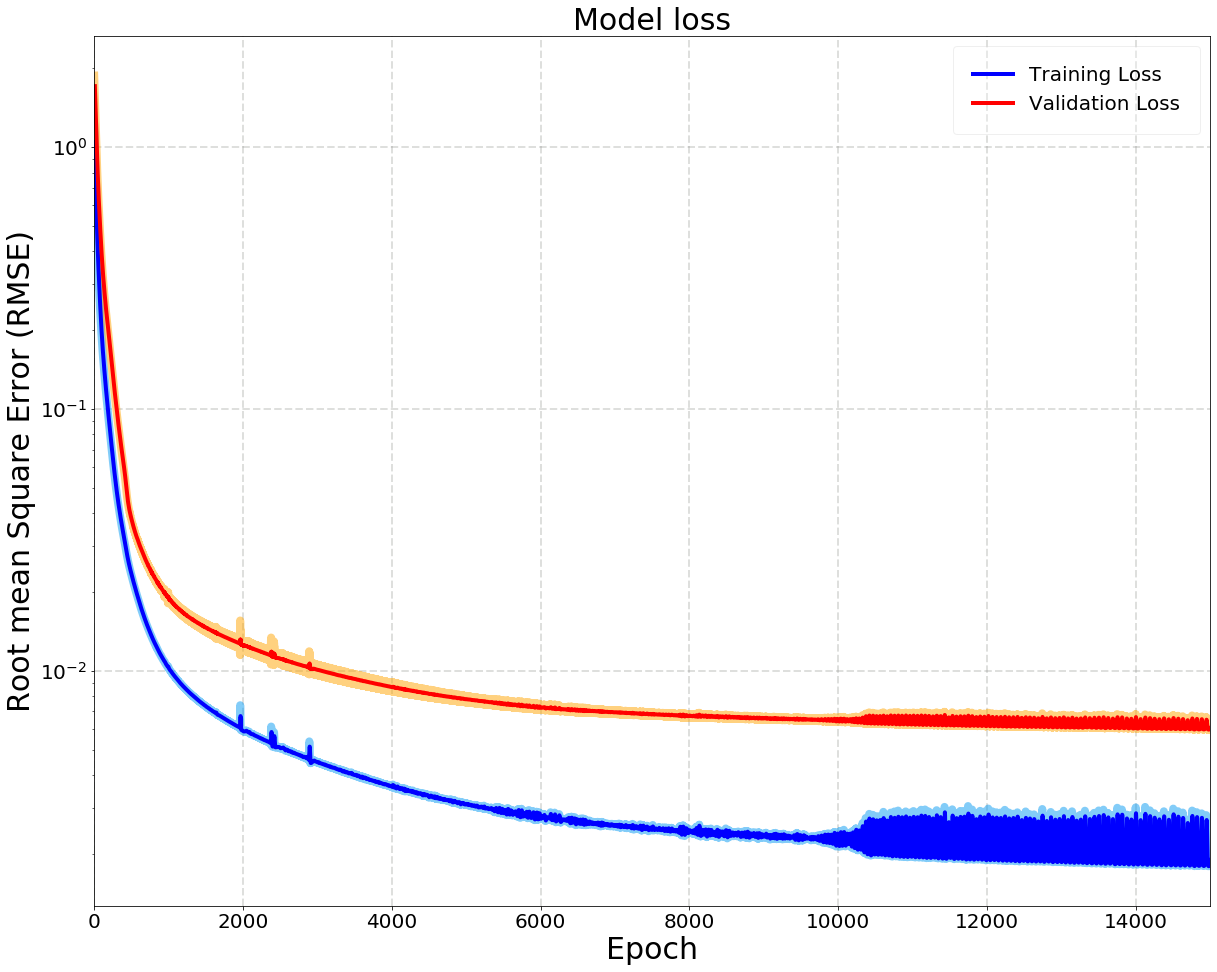

In [25]:
# Evalute netwroks training performance
df = pd.DataFrame(history.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()

plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')

plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("Root mean Square Error (RMSE)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_xlim(0,15000)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.yscale("log")
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

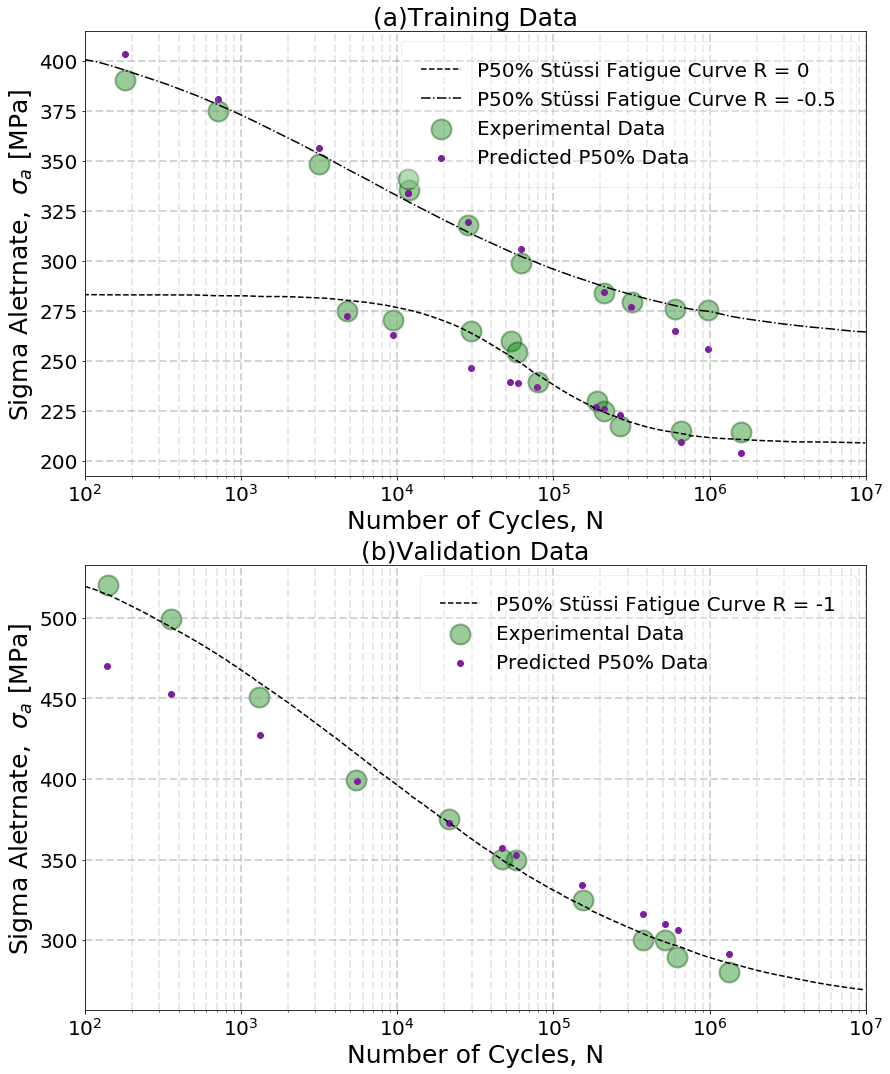

In [26]:
# Create a figure
plt.figure(figsize=(14,18))
# Subplot1 training data
plt.subplot(2,1,1)
preds = combinedANNmodel.predict([X1_train, X2_train])
plt.scatter(np.power(10,[ExpX_train["nNormalized"]*7]),ExpY_train*568/2,color="#008000",
            alpha = 0.4,s=400,linewidth=2, edgecolors="#054907",label = 'Experimental Data')
plt.scatter(np.power(10,[X1_train["nNormalized"][4:-2]*7]),preds[:,0][4:-2]*568/2,
            color="#7E1E9C",label = 'Predicted P50% Data') #observerd 
plt.plot( np.power(10,np.array ( X_train_P50_HR[:600]).reshape([-1,1]) * 7),
         Y_train_P50_HR[:600]*568/2,color="black", linestyle='--',label = 'P50% Stüssi Fatigue Curve R = 0')
plt.plot( np.power(10,np.array ( X_train_P50_HR[600:]).reshape([-1,1]) * 7),
         Y_train_P50_HR[600:]*568/2,color="black", linestyle='-.',label = 'P50% Stüssi Fatigue Curve R = -0.5')
plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.xlim([100,10000000])
plt.xscale('log')

# Subplot2 validation data
plt.subplot(2,1,2)
preds = combinedANNmodel.predict([X1_valid, X2_valid])
plt.scatter(np.power(10,[ExpX_valid["nNormalized"]*7]),ExpY_valid*568/2,color="#008000", alpha = 0.4,s=400,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
plt.scatter(np.power(10,[X1_valid["nNormalized"]*7]),preds[:,0]*568/2,color="#7E1E9C",label = 'Predicted P50% Data') 
plt.plot( np.power(10,np.array (X_valid_P50_HR).reshape([-1,1]) * 7),Y_valid_P50_HR*568/2,color="black",
         linestyle='--',label = 'P50% Stüssi Fatigue Curve R = -1')
plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(b)Validation Data", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.xlim([100,10000000])
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()



# Calculate correaltion factor for training and validation data

In [27]:
# Training data correaltion
preds =  combinedANNmodel.predict([X1_train, X2_train])
train_corr = scipy.stats.pearsonr((np.array(list(preds[:,0]))*568/2), (np.array(list(Y1_train['Target'])))*568/2)
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  combinedANNmodel.predict([X1_valid, X2_valid])
val_corr = scipy.stats.pearsonr((np.array(list(preds[:,0]))*568/2), (np.array(list(Y1_valid['Target'])))*568/2)
print ('Validation Person correlation is  ', val_corr)

# Training and validation error 
from sklearn.metrics import mean_squared_error
preds = combinedANNmodel.predict([X1_train, X2_train])
print('Prediction error of Training Data',mean_squared_error(preds ,np.concatenate((Y1_train, Y2_train), axis=1))/2)
preds = combinedANNmodel.predict([X1_valid, X2_valid])
print('Prediction error of validation Data',mean_squared_error(preds , np.concatenate((Y1_valid, Y1_valid), axis=1))/2)


Training Person correlation is   (0.9962935653464269, 3.0983140890898005e-29)
Validation Person correlation is   (0.9958429087301774, 9.70927882045148e-12)
Prediction error of Training Data 0.0007489194999155649
Prediction error of validation Data 0.0028005670513910046


# Plot real data vs predicted data

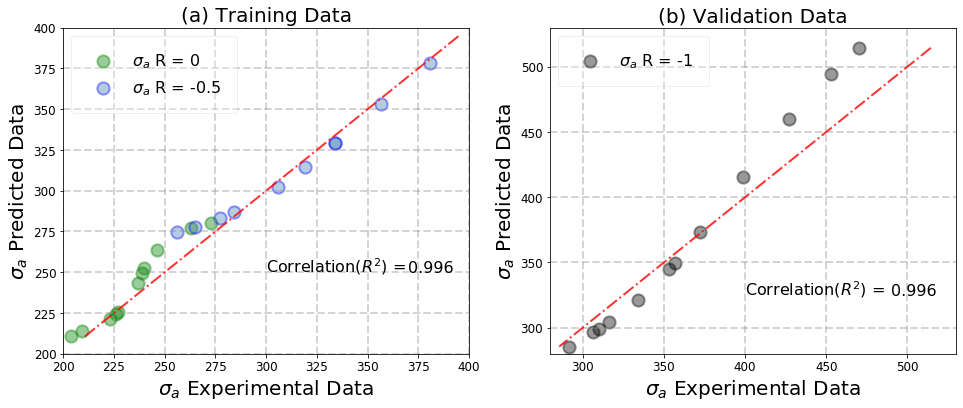

In [28]:
plt.figure(figsize=(16,6))

# Subplot1 training data
plt.subplot(1,2,1)
preds = combinedANNmodel.predict([X1_train, X2_train])
plt.plot(np.sort(Y1_train[4:-11]*568/2,axis= 0),np.sort(Y1_train[4:-11]*568/2,axis= 0),color="red",
         linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(preds[:,0][4:-13]*568/2,Y1_train[4:-13]*568/2,color="green",edgecolors="green",
            s =150,alpha = 0.4,linewidth=2, label = ( r'$σ_{a}$' ' R = 0')) #observerd 
plt.scatter(preds[:,0][15:-2]*568/2,Y1_train[15:-2]*568/2,color="steelblue",edgecolors="#0000FF",
            s =150,alpha = 0.4,linewidth=2,label = ( r'$σ_{a}$' ' R = -0.5')) #observerd 
plt.xlabel(( r'$σ_{a}$' ' Experimental Data'),size=20)
plt.ylabel(( r'$σ_{a}$' ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1)
plt.title("(a) Training Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlim([200,400])
plt.ylim([200,400])
plt.text(300, 250, ('Correlation' r'$(R^{2}$' ') = '), fontsize = 16)
plt.text(370, 250, round (train_corr[0],3) , fontsize = 16)

# subplot2 validation data
plt.subplot(1,2,2)
preds = combinedANNmodel.predict([X1_valid, X2_valid])
plt.plot(Y1_valid*568/2,Y1_valid*568/2,color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(preds[:,0]*568/2,Y1_valid*568/2,color="black",edgecolors="black", s =150,
            alpha = 0.4,linewidth=2,label = ( r'$σ_{a}$' ' R = -1')) 
plt.xlabel(( r'$σ_{a}$' ' Experimental Data'),size=20)
plt.ylabel(( r'$σ_{a}$' ' Predicted Data'),size=20)
plt.title("(b) Validation Data", size = 20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlim([280,530])
plt.ylim([280,530])
plt.text(400, 325, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(490, 325, round (val_corr[0],3) , fontsize = 16)
plt.show()


# Artificial constant life diagram for fatigue data by combind ANN: failure probability of 50%

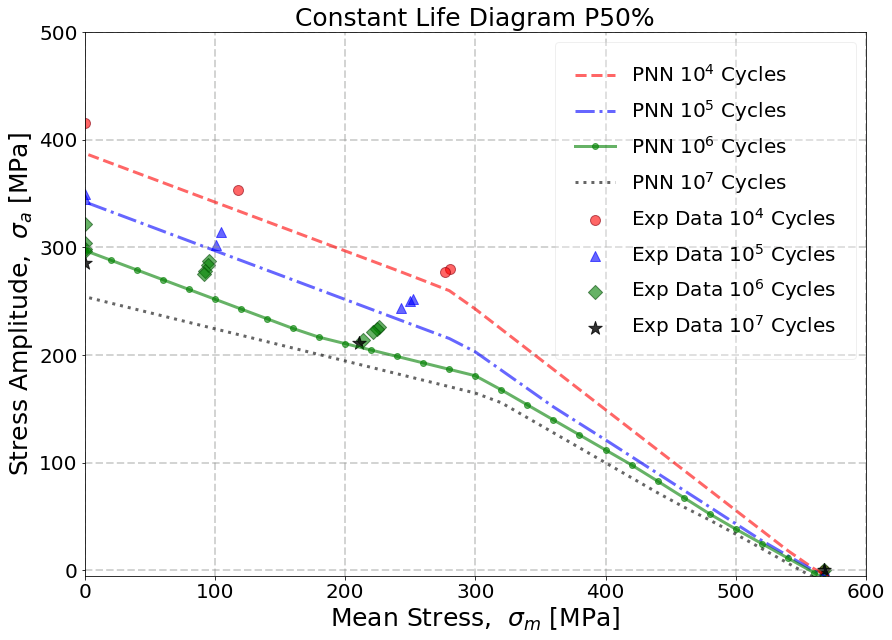

In [33]:
# generate sigma M data
sigmaM =np.arange(-1000,2000,20, dtype = float)
sigmaM_nor = sigmaM/568 # normalize sigmaM

# generate 10^4 cycles data
N104= np.ones(150)*10000.0
N104_nor = np.log10( N104 )/7
test_data104 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N104_nor})
preds104 = combinedANNmodel.predict([test_data104,test_data104])


# generate 10^5 cycles data
N105= np.ones(150)*100000.0
N105_nor = np.log10( N105 )/7
test_data105 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N105_nor})
preds105 = combinedANNmodel.predict([test_data105,test_data105] )

# generate 10^6 cycles data
N106= np.ones(150)*1000000.0
N106_nor = np.log10( N106 )/7
test_data106 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N106_nor})
preds106 = combinedANNmodel.predict([test_data106,test_data106])

# generate 10^7 cycles data
N107= np.ones(150)*10000000.0
N107_nor = np.log10( N107 )/7
test_data107 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N107_nor})
preds107 = combinedANNmodel.predict([test_data107,test_data107])

# Process all data to create CLD graph with Exp data
Alldata_train = [X_train[:], X_valid[3:]]
Alldata_train = pd.concat(Alldata_train).reset_index(drop=True)
Alldata_valid = [Y_train[:], Y_valid[3:]]
Alldata_valid = pd.concat(Alldata_valid).reset_index(drop=True)
Alldata = [Alldata_train,Alldata_valid]
Alldata = pd.concat(Alldata , axis= 1)
Alldata['sigmaMean'] = Alldata['sigmaMeanNormalized']*568
Alldata['N'] = 10**(Alldata['nNormalized']*7)
Alldata['sigmaA'] = Alldata['Target']*284
AllExp104 = Alldata[(Alldata['N']>1000) & (Alldata['N']<10000)]
AllExp104.drop([26], inplace= True)
AllExp105 = Alldata[(Alldata['N']>10000) & (Alldata['N']<100000)]
AllExp105.drop([6,18,19,30], inplace= True)
AllExp106 = Alldata[(Alldata['N']>100000) & (Alldata['N']<1000000)]
AllExp107 = Alldata[(Alldata['N']>1000000)]

# Plot resulted CLD

plt.figure(figsize=(14,10))

plt.plot(test_data104['sigmaMeanNormalized']*568,preds104[:,0]*284,color="red",
            alpha = 0.6,linewidth=3, linestyle='--',label = ('PNN '  r'$10^{4}$' ' Cycles'))
plt.plot(test_data105['sigmaMeanNormalized']*568,preds105[:,0]*284,color="blue",
            alpha = 0.6,linewidth=3,linestyle='-.',label = ('PNN '  r'$10^{5}$' ' Cycles'))
plt.plot(test_data106['sigmaMeanNormalized']*568,preds106[:,0]*284,'go-',color="green",
            alpha = 0.6,linewidth=3, label = ('PNN '  r'$10^{6}$' ' Cycles'))
plt.plot(test_data107['sigmaMeanNormalized']*568,preds107[:,0]*284,color="black",
            alpha = 0.6,linewidth=3,linestyle=':',label = ('PNN '  r'$10^{7}$' ' Cycles'))
plt.scatter(AllExp104['sigmaMean'], AllExp104['sigmaA'],color="red",
            alpha = 0.6,s=100,linewidth=1, label = ('Exp Data '  r'$10^{4}$' ' Cycles'),edgecolors="#8c000f")
plt.scatter(AllExp105['sigmaMean'], AllExp105['sigmaA'],color="blue",
            alpha = 0.6,s=100,linewidth=1,  marker='^',label = ('Exp Data '  r'$10^{5}$' ' Cycles'),edgecolors="#0000ff")
plt.scatter(AllExp106['sigmaMean'], AllExp106['sigmaA'],color="green",
            alpha = 0.6,s=100,linewidth=1,  marker='D',label = ('Exp Data '  r'$10^{6}$' ' Cycles'),edgecolors="#054907")
plt.scatter(AllExp107['sigmaMean'], AllExp107['sigmaA'] ,color="black",
            alpha = 0.8,s=200,linewidth=1,  marker='*',label = ('Exp Data '  r'$10^{7}$' ' Cycles'),edgecolors="black")

plt.xlabel(('Mean Stress,  ' r'$σ_{m}$' ' [MPa]'),size=25)
plt.ylabel(('Stress Amplitude,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("Constant Life Diagram P50%", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim ([-5,500])
plt.xlim ([0,600])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)

# PNN network with pipework data Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 0.001-0.002


# Import Data

In [168]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 001-002.csv')

# Prepare Data

In [169]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data_final = scaler.fit_transform(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.3, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

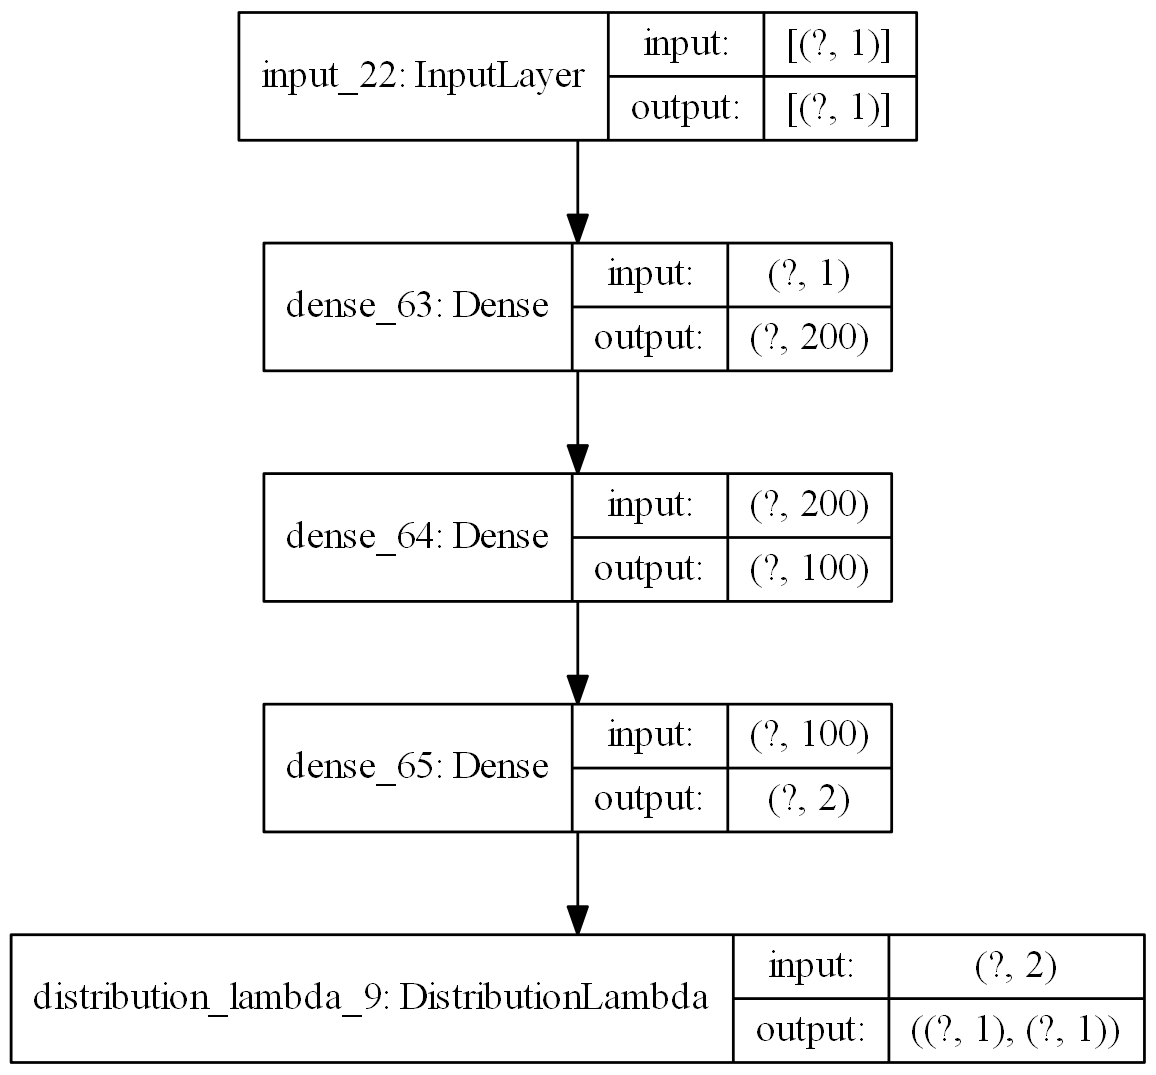

In [179]:

# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25 )

# Create the PNN
inputs = Input(shape=(1,))
hidden1 = Dense(200,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(100,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(hidden1)
keras.layers.Dropout(rate=0.2)
params = Dense(2)(hidden2)

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR001 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR001.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR001, to_file='model.png', show_shapes=True, show_layer_names=True,
                       rankdir='TB',expand_nested=False, dpi=200)


# Training model

In [171]:
history1 = modelPnnPipeworkSR001.fit(train_data, train_traget, epochs=8000, verbose=0,
                                     validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

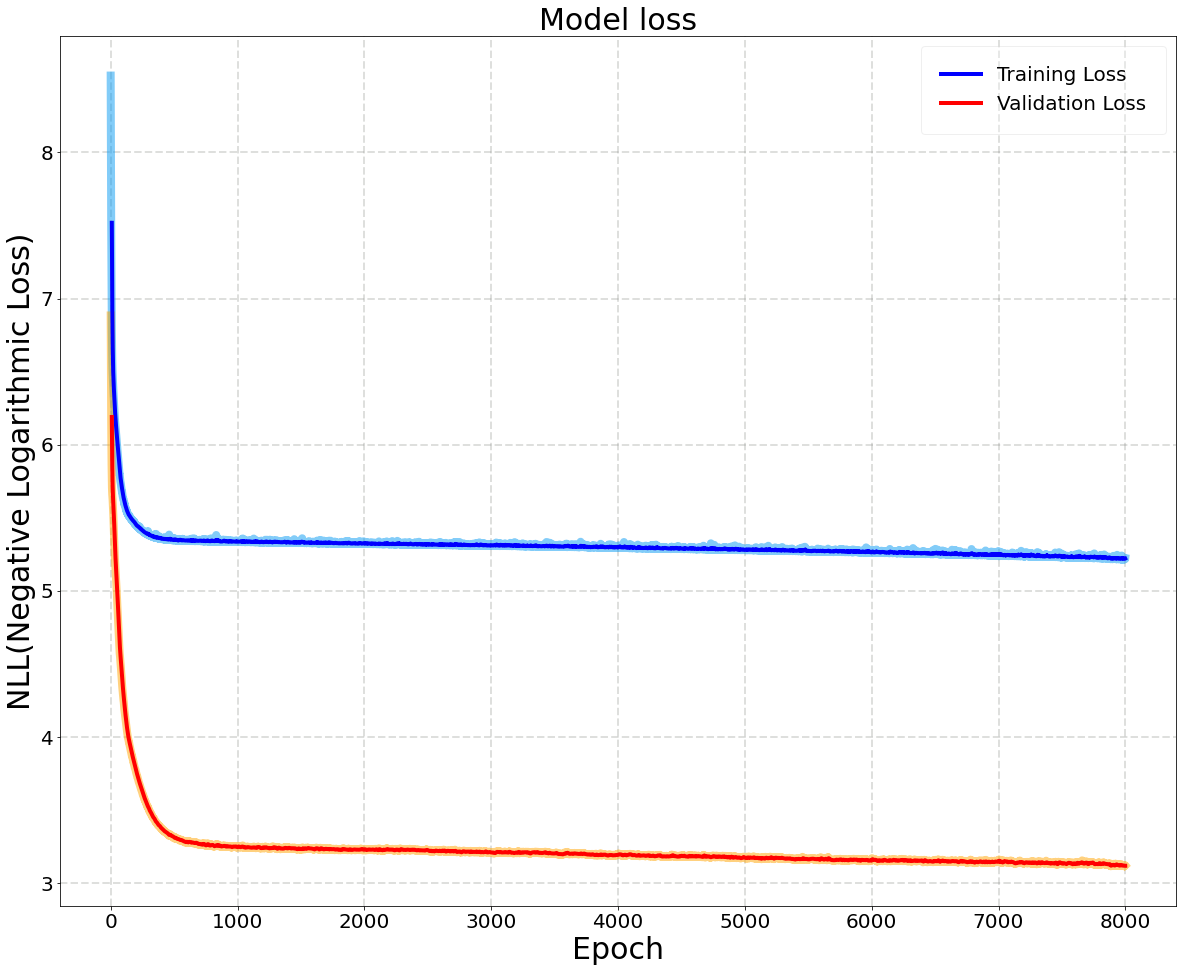

In [172]:
# Plot Model Loss
modelPnnPipeworkSR001 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history1.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

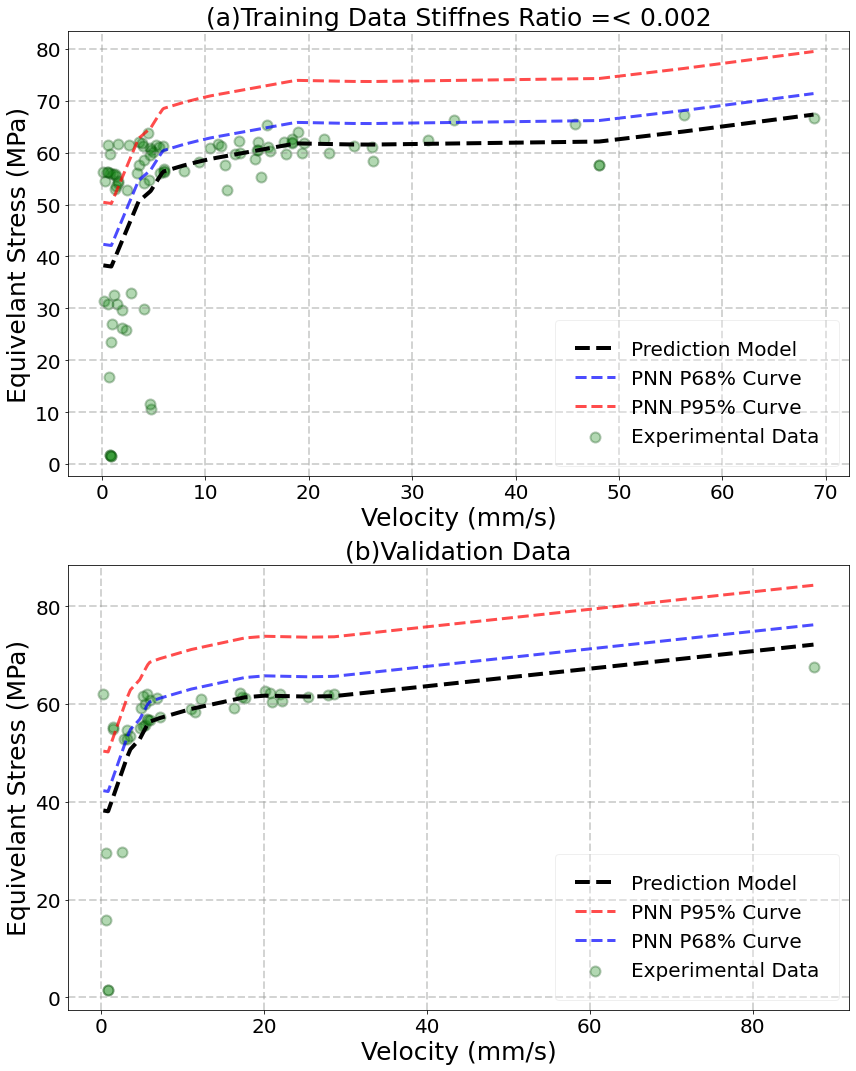

In [173]:
# Get model uncertainty
modelPnnPipeworkSR001_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR001.predict(train_data)
plt.scatter((train_set[:,0]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
            (train_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')

preds_sd = (preds+ 1* modelPnnPipeworkSR001_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 3* modelPnnPipeworkSR001_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(a)Training Data Stiffnes Ratio =< 0.002",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR001.predict(test_data)
plt.scatter((test_data)* (scaler.var_[0]**0.5)+scaler.mean_[0],
            (test_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+3* modelPnnPipeworkSR001_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSR001_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')


plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
#plt.ylim([0,110])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [174]:
# Training data correaltion
# preds = modelPnnPipeworkSR001.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSR001.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)


Training Person correlation is   (0.7250722760867742, 8.253615117423493e-08)


# PNN network with pipework data Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 0.002-0.1


# Import Data

In [187]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 01-02.csv')

# Prepare Data

In [188]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data_final = scaler.fit_transform(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.3, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

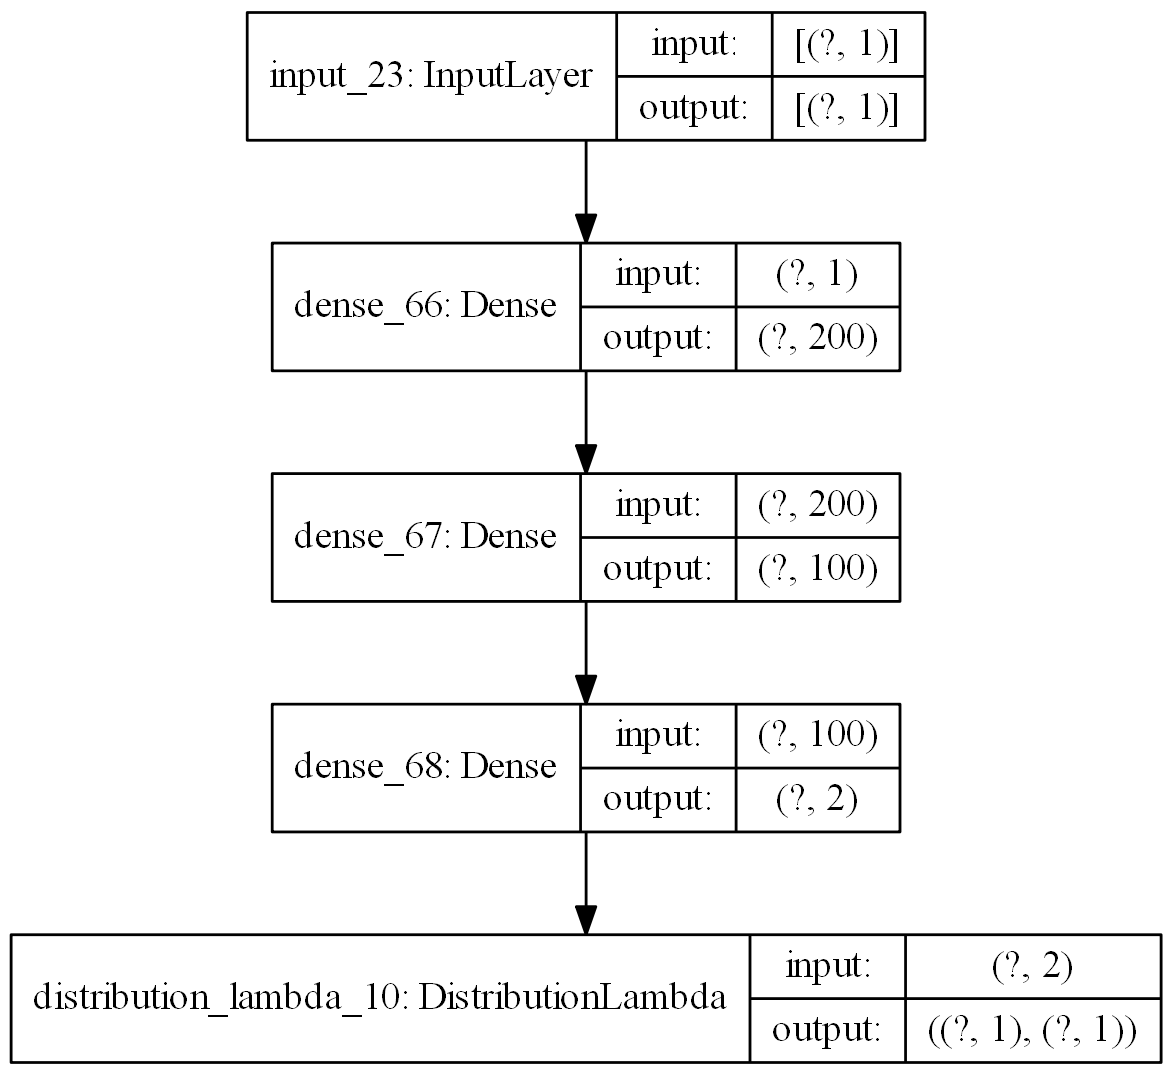

In [180]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25 )

# Create the PNN
inputs = Input(shape=(1,))
hidden1 = Dense(200,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(100,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(hidden1)
keras.layers.Dropout(rate=0.2)
params = Dense(2)(hidden2)

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR01.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR01, to_file='model.png', show_shapes=True,
                       show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [181]:
history2 = modelPnnPipeworkSR01.fit(train_data, train_traget, epochs=2000, verbose=0,
                                    validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

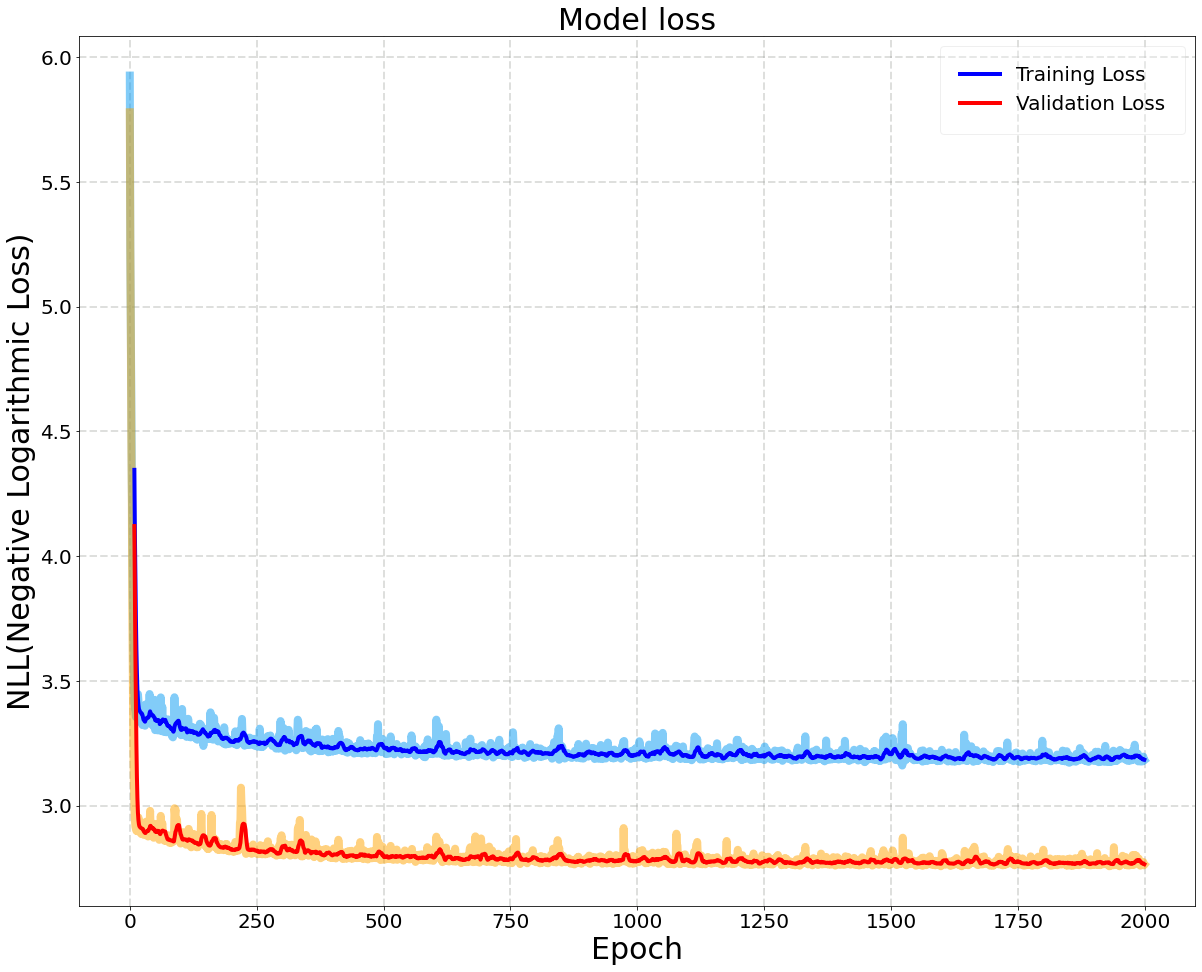

In [183]:
# Plot Model Loss
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history2.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

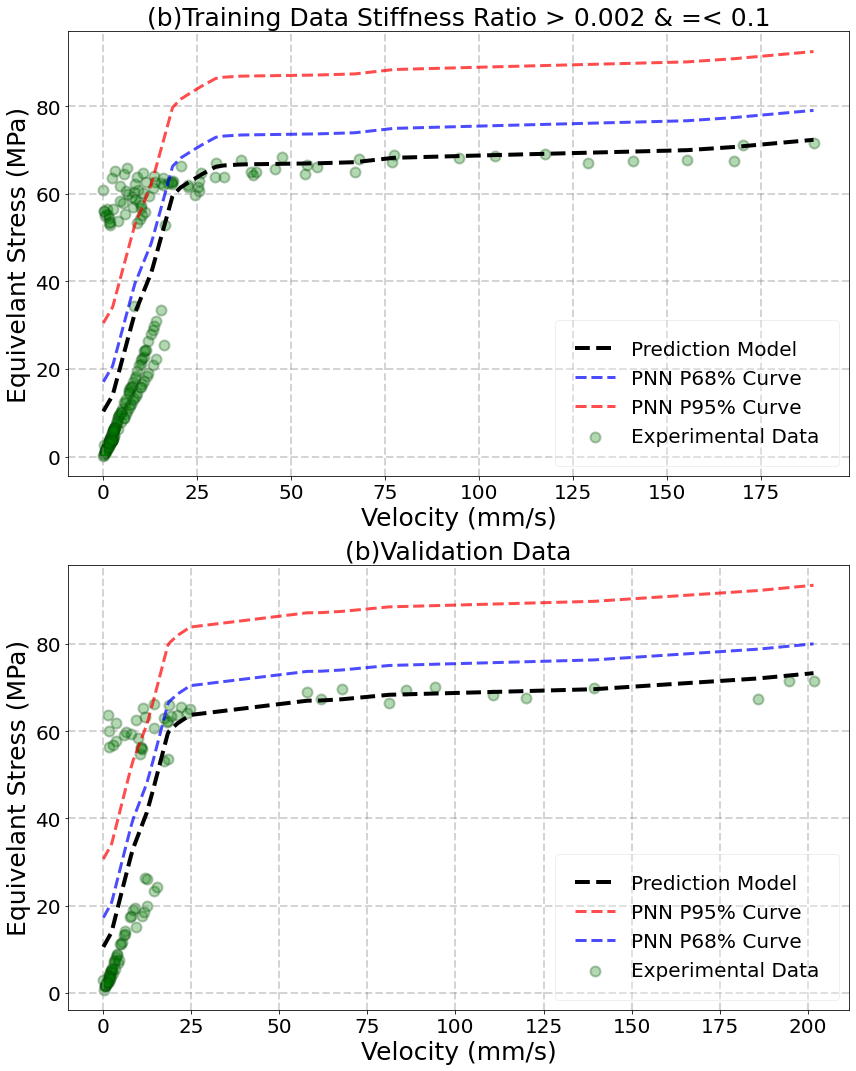

In [189]:
# Get model uncertainty
modelPnnPipeworkSR01_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR01.predict(train_data)
plt.scatter((train_set[:,0]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
            (train_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 3* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Training Data Stiffness Ratio > 0.002 & =< 0.1",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR01.predict(test_data)
plt.scatter((test_data)* (scaler.var_[0]**0.5)+scaler.mean_[0],
            (test_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+3* modelPnnPipeworkSR01_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

preds_sd = preds+ 1* modelPnnPipeworkSR01_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


In [190]:
# Training data correaltion
# preds =  modelPnnPipeworkSR01.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  modelPnnPipeworkSR01.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.7879353540230651, 1.657880743601986e-21)


# PNN network with pipework data Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 5-20


# Import Data

In [191]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 5-20.csv')

# Prepare Data

In [192]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data_final = scaler.fit_transform(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.3, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

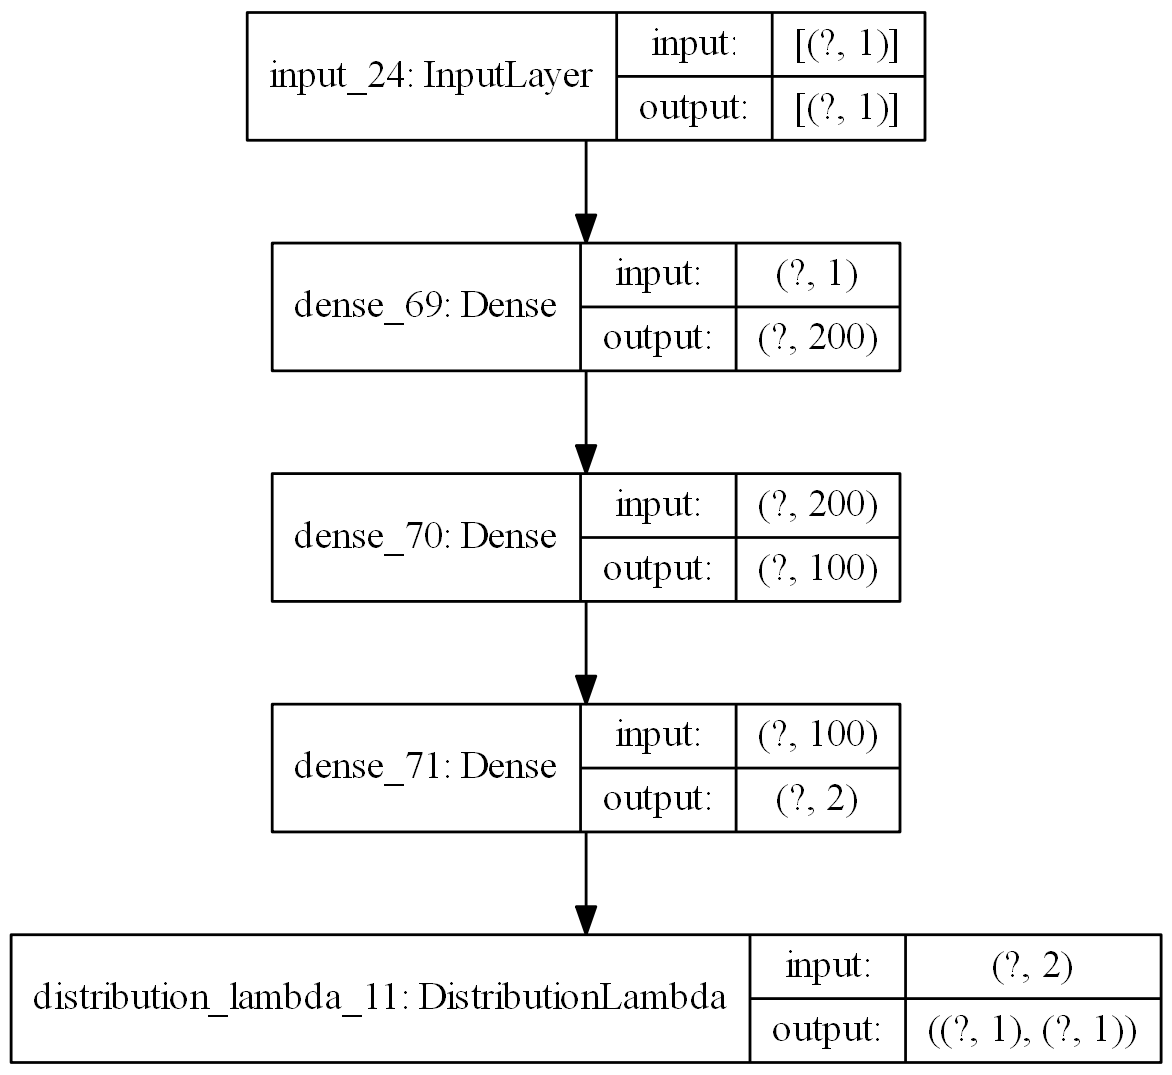

In [193]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25 )

# Create the PNN
inputs = Input(shape=(1,))
hidden1 = Dense(200,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(100,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(hidden1)
keras.layers.Dropout(rate=0.2)
params = Dense(2)(hidden2)

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR5 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR5.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR5, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [194]:
history3 = modelPnnPipeworkSR5.fit(train_data, train_traget, epochs=2000,
                                   verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

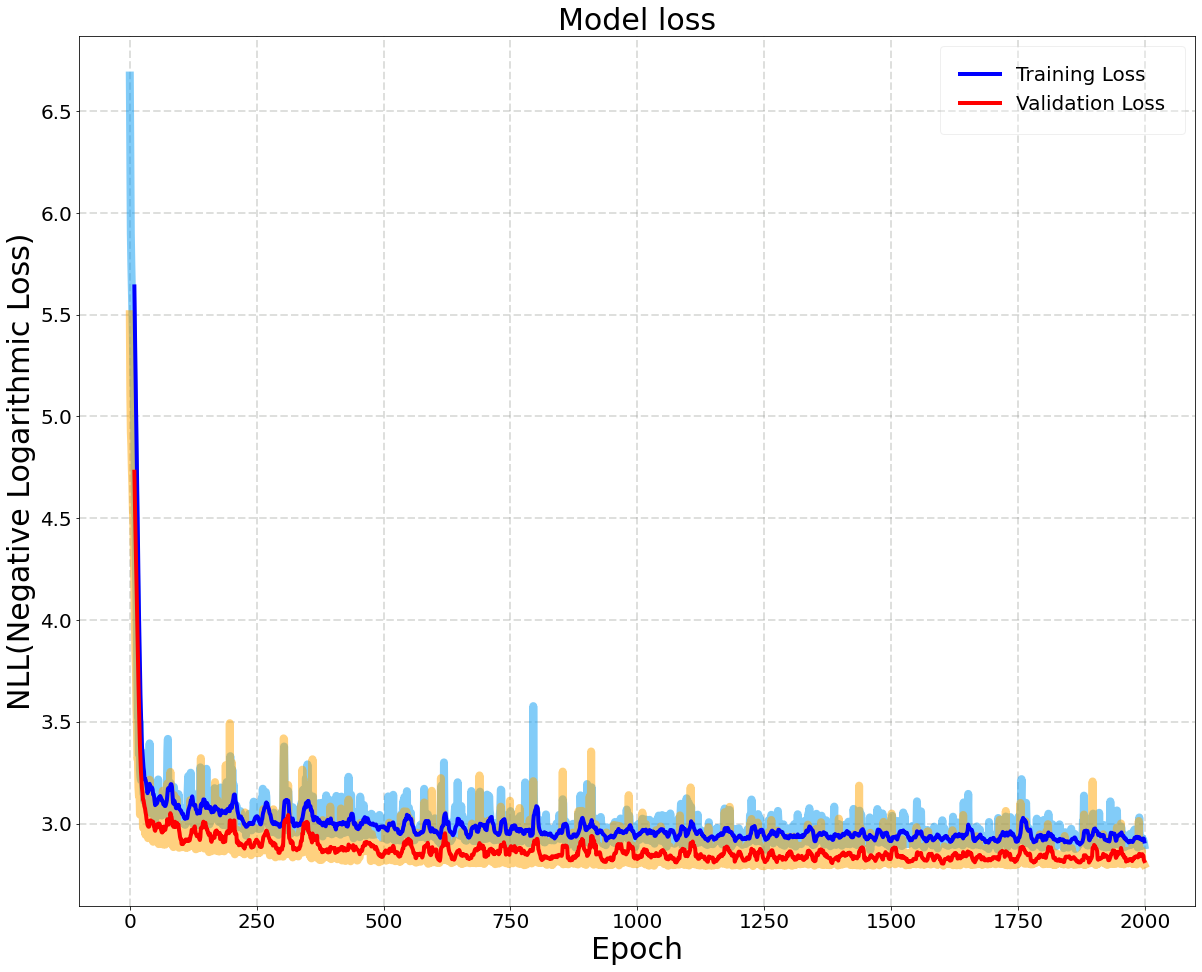

In [196]:
# Plot Model Loss
modelPnnPipeworkSR5 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history3.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

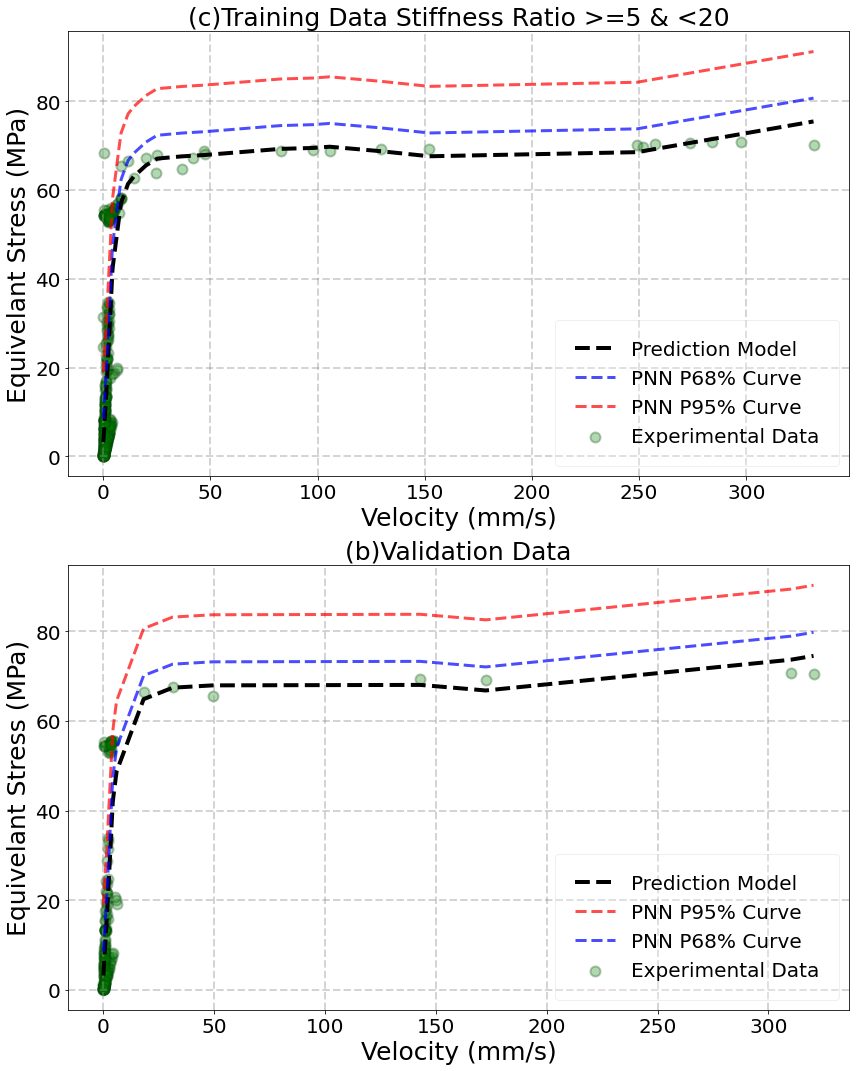

In [198]:
# Get model uncertainty
modelPnnPipeworkSR5_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR5.predict(train_data)
plt.scatter((train_set[:,0]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
            (train_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSR5_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 3* modelPnnPipeworkSR5_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(c)Training Data Stiffness Ratio >=5 & <20",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR5.predict(test_data)
plt.scatter((test_data)* (scaler.var_[0]**0.5)+scaler.mean_[0],
            (test_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+3* modelPnnPipeworkSR5_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSR5_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [199]:
# Training data correaltion
# preds = modelPnnPipeworkSR5.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSR5.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.7385640959526303, 4.319008107771039e-31)


# PNN network with pipework data Constant variant (Velocity vs Stress)
## All Data 


# Import Data

In [200]:
# get data from csv file
Data = pd.read_csv('Pipework data SR All.csv')

# Prepare Data

In [201]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data_final = scaler.fit_transform(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.3, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

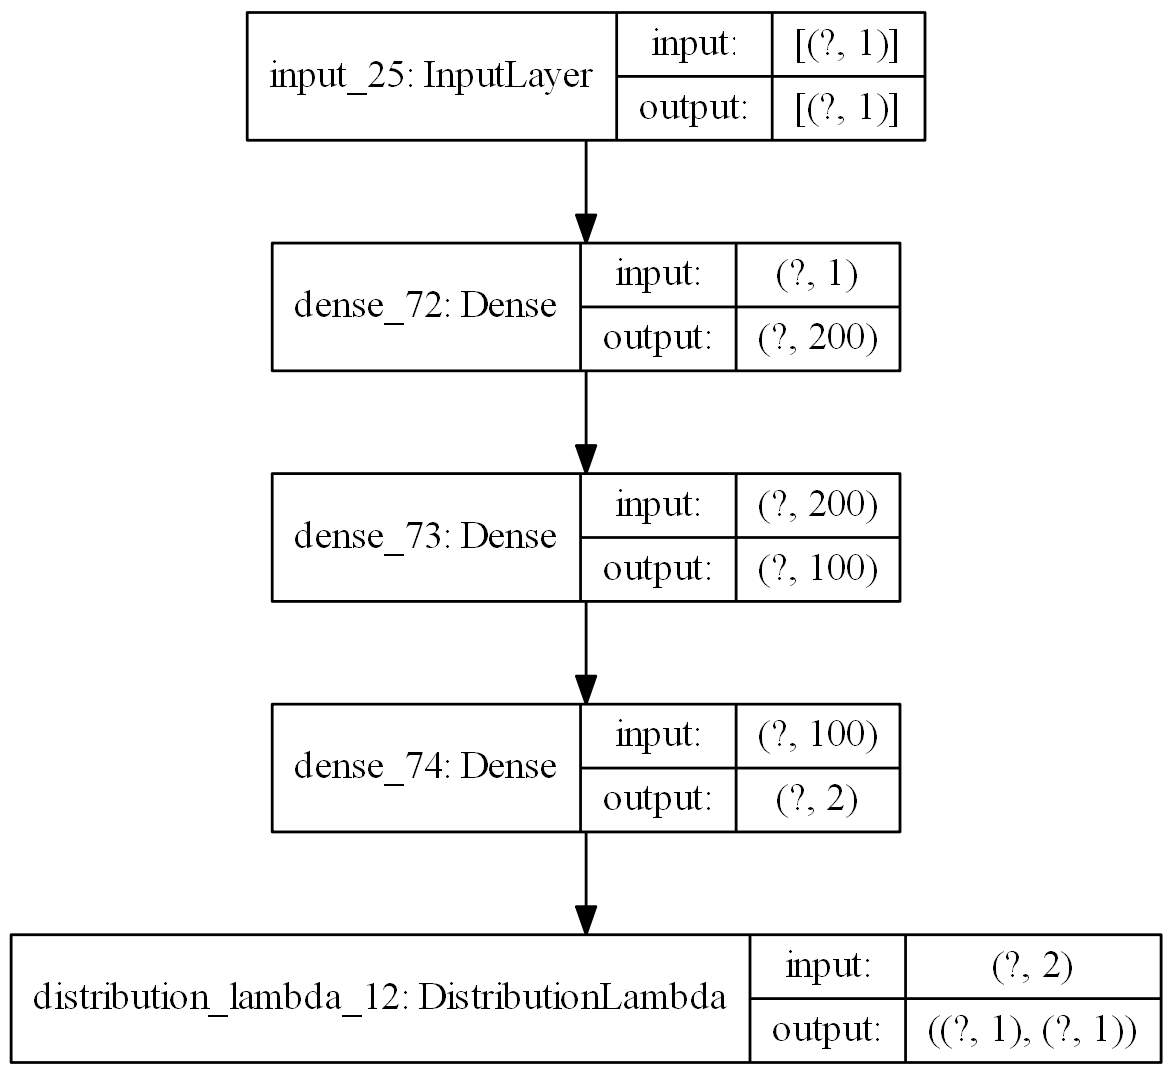

In [202]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.2 )

inputs = Input(shape=(1,))
hidden1 = Dense(200,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(100,activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                kernel_regularizer=keras.regularizers.l2(0.001))(hidden1)
keras.layers.Dropout(rate=0.2)
params = Dense(2)(hidden2)

# Create the PNN
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSRAll = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSRAll.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSRAll, to_file='model.png', show_shapes=True,
                       show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [203]:
history3 = modelPnnPipeworkSRAll.fit(train_data, train_traget, epochs=2000, verbose=0,
                                     validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

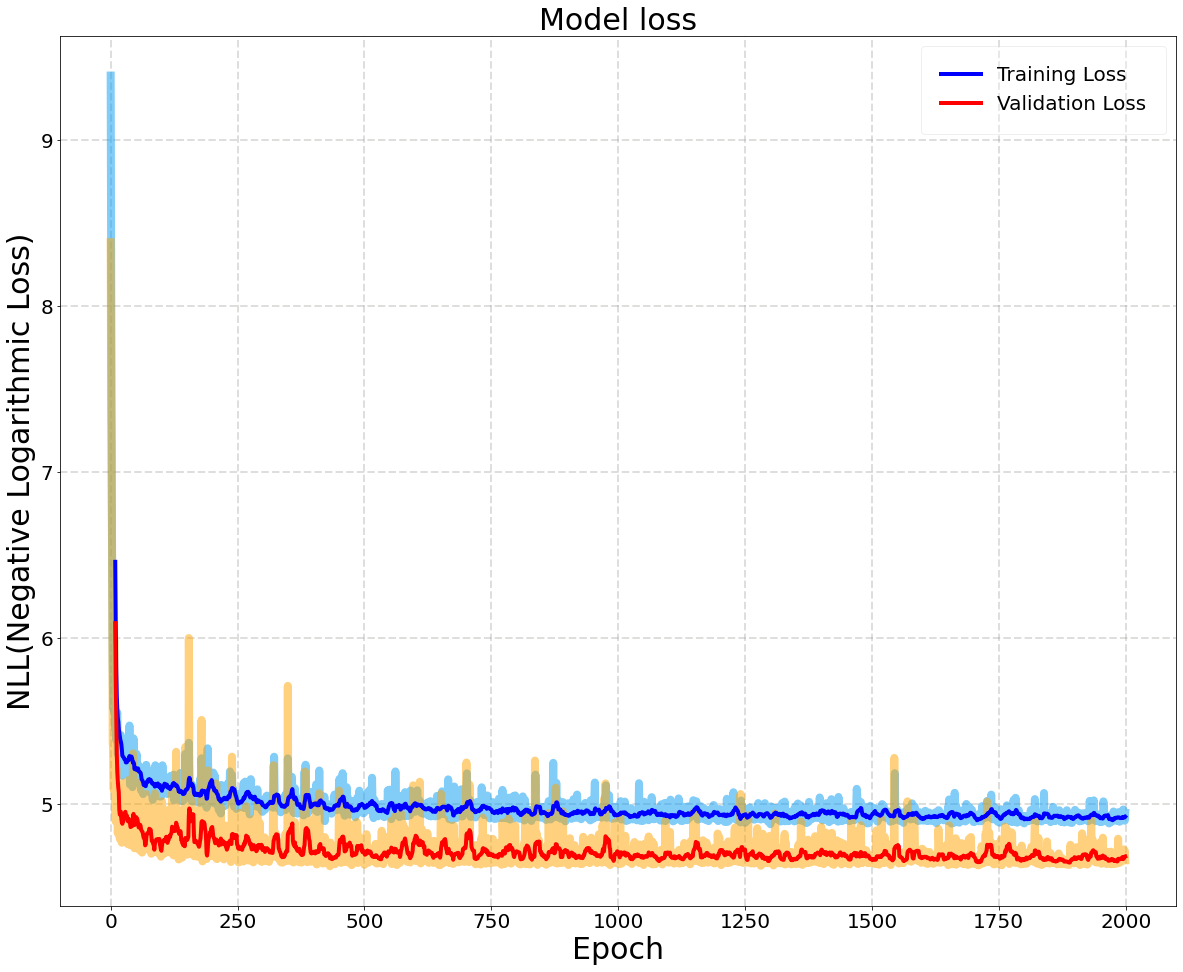

In [204]:
# Plot Model Loss
modelPnnPipeworkSRAll = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history3.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

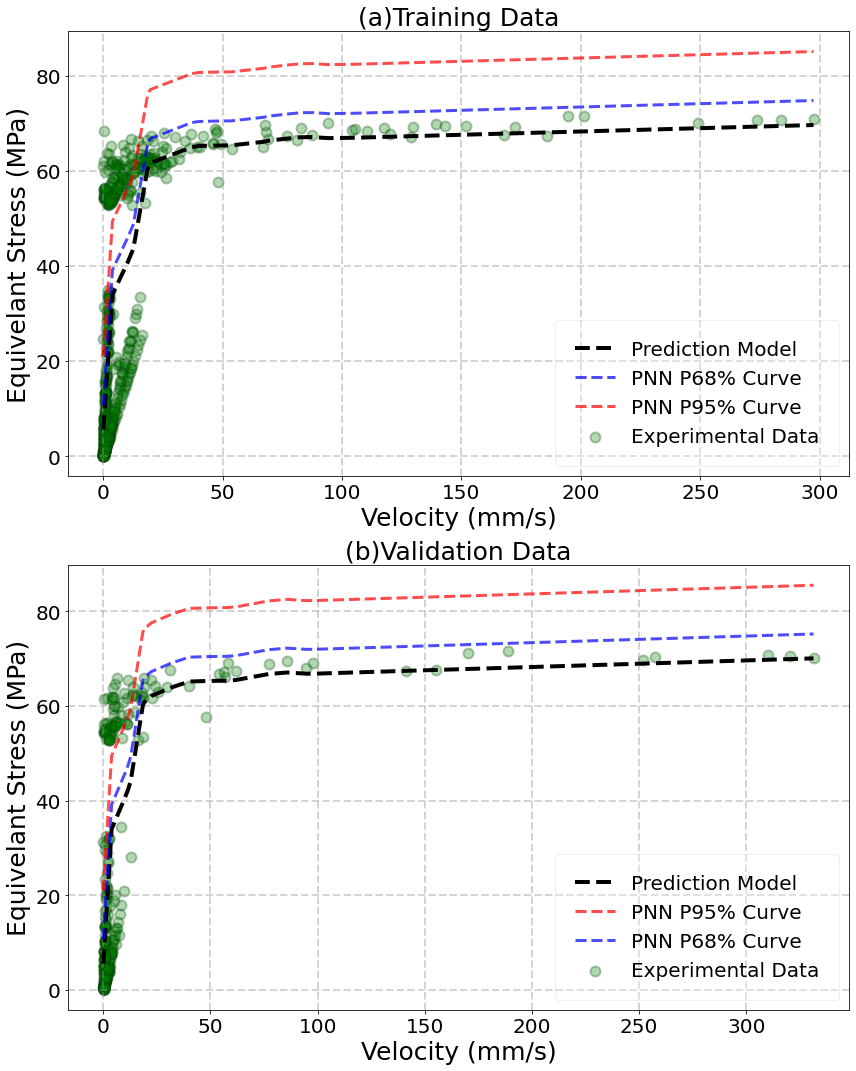

In [216]:
# Get model uncertainty
modelPnnPipeworkSRAll_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSRAll.predict(train_data)
plt.scatter((train_set[:,0]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
            (train_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 3* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.plot((train_set[:,0][ind]* (scaler.var_[0]**0.5)+scaler.mean_[0]),
         (preds_sd[ind]* (scaler.var_[2]**0.5)+scaler.mean_[2]),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSRAll.predict(test_data)
plt.scatter((test_data)* (scaler.var_[0]**0.5)+scaler.mean_[0],
            (test_traget)* (scaler.var_[2]**0.5)+scaler.mean_[2],color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+3* modelPnnPipeworkSRAll_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSRAll_sd.predict(test_data)
plt.plot((test_data[ind])* (scaler.var_[0]**0.5)+scaler.mean_[0],
         (preds_sd[ind])* (scaler.var_[2]**0.5)+scaler.mean_[2],
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [215]:
# Training data correaltion
preds = modelPnnPipeworkSRAll.predict(train_data)
train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSRAll.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.7466801140183541, 1.5185663353764044e-128)
Training Person correlation is   (0.7585550775988833, 7.20664158804876e-59)


# Plot real data vs predicted data

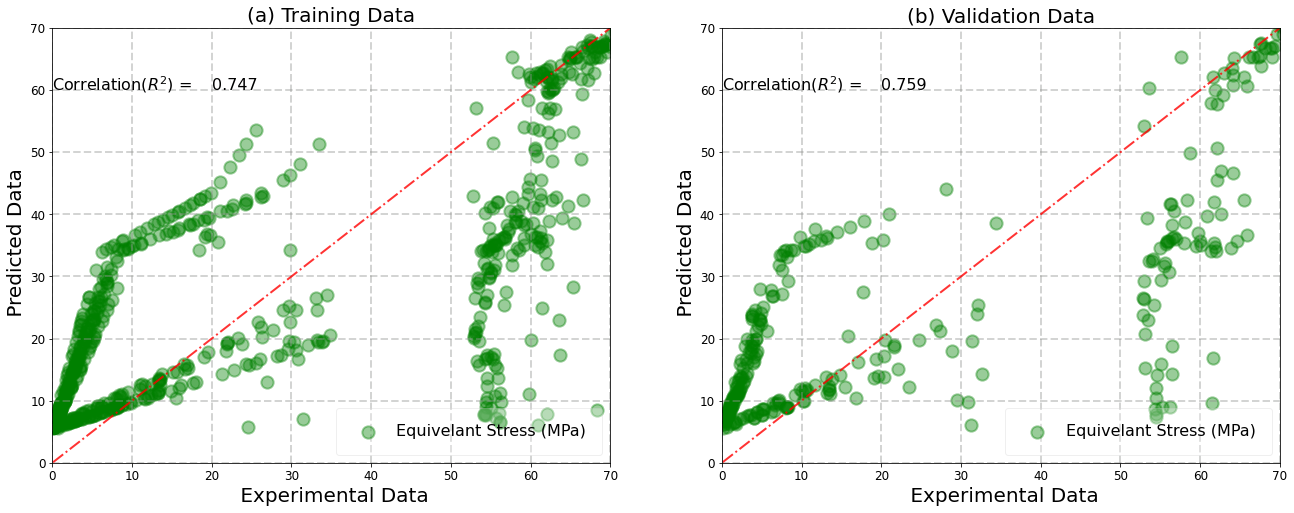

In [214]:
# Create figure
plt.figure(figsize=(22,8))

# Subplot1 training data
plt.subplot(1,2,1)
preds = modelPnnPipeworkSRAll.predict(train_data)
plt.plot((train_traget[np.argsort (train_traget,axis = 0)]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         (train_traget[np.argsort (train_traget,axis = 0)]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(train_traget* (scaler.var_[2]**0.5)+scaler.mean_[2],preds* (scaler.var_[2]**0.5)+scaler.mean_[2],
            color="green",edgecolors="green",
            s =150,alpha = 0.4,linewidth=2, label = "Equivelant Stress (MPa)") 
plt.xlabel(( ' Experimental Data'),size=20)
plt.ylabel(( ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1,loc=4)

plt.title("(a) Training Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.text(0, 60, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(20, 60, round (train_corr[0],3) , fontsize = 16)
plt.xlim([0,70])
plt.ylim([0,70])

# subplot2 validation data
plt.subplot(1,2,2)
preds = modelPnnPipeworkSRAll.predict(test_data)
plt.plot((test_traget[np.argsort (test_traget,axis = 0)]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         (test_traget[np.argsort (test_traget,axis = 0)]* (scaler.var_[2]**0.5)+scaler.mean_[2]),
         color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(test_traget* (scaler.var_[2]**0.5)+scaler.mean_[2],
            preds * (scaler.var_[2]**0.5)+scaler.mean_[2],color="green",edgecolors="green",
            s =150,alpha = 0.4,linewidth=2, label = "Equivelant Stress (MPa)") 

plt.xlabel(( ' Experimental Data'),size=20)
plt.ylabel(( ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1,loc=4)
plt.title("(b) Validation Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.text(0, 60, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(20, 60, round (val_corr[0],3) , fontsize = 16)
plt.xlim([0,70])
plt.ylim([0,70])
plt.show()